In [1]:
# look into an n-gram strategy for text prediction

In [2]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

## define helper functions

In [5]:
# initialize 7 margins
margins = {'amount': 600,
          'authorization': 600,
          'date' : 600,
          'count' : 600,
          'intention' : 600,
          'utilization':600,
          'unknown':600}

In [6]:
def get_relevant_key_word_tokens(df_col, most_common = 10, inverse = False, least_common = 10):
    '''Takes a data frame and column name and returns a list of key word tokens. If inverse, then it will return the 10 least common tokens'''
    # make sure the column is strings
    for cell in df_col:
        assert(type(cell) == str)
    text_list = [t.lower() for t in df_col]
    text_string = ''
    for t in text_list:
        text_string = text_string + t + ' '
    text_tokens = [w for w in word_tokenize(text_string) if (w.isalnum() and w not in stopwords.words('english'))]
    if inverse:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common()).tail(10)
    else:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common(most_common))

    key_tokens.columns = ['key_tok', 'kt_count']
    
    return key_tokens


def define_nominated_paragraphs(filing, key_tokens, margin):
    '''takes an html filing, key_tokens, paragraph margin and returns nominated paragraphs'''
    
    # read in an html
    with open(filing) as file:
        file_html = file.read()
        
    # parse html
    parsed_html = BeautifulSoup(file_html, 'lxml')
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by addin margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraph bounds
    candidate_paragraphs = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(string_filing):
            rightbound = len(string_filing)

        par_bounds = (leftbound, rightbound) 
        candidate_paragraphs.append(par_bounds)
    
    return candidate_paragraphs, string_filing

In [7]:
def define_nominated_texts(par, key_tokens, margin):
    '''takes a paragraph, key_tokens, text margin and returns nominated texts'''
    
    ##################------- Predict texts ------##############################################
    #define candidate texts by adding margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[:])):
        kt = key_tokens.key_tok[i]
        if kt not in par:
            continue
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, par)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate texts bounds
    candidate_texts = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(par):
            rightbound = len(par)

        par_bounds = (leftbound, rightbound) 
        candidate_texts.append(par_bounds)
    
    return candidate_texts, par

In [8]:
def measure_inclusion(predicted_par, test_par, verbose = False):
    '''takes two strings, eliminates excess spaces and new lines and stopwords, casts to lower, tokenizes and then compares inclusion'''
    # pre process paragraphs and generate tokens
    pred = re.sub(r'\n+', ' ', predicted_par)
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    pred_tokens = [wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))]
    if len(pred) == 0:
        pred_tokens = [np.nan]
    
    test = re.sub(r'\n+', ' ', test_par)
    test = re.sub(r'\s+', ' ', test)
    test = test.lower()
    test_tokens = [wt for wt in word_tokenize(test) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    # calculate total inclusion
    total_inclusion = False
    if test in pred:
        total_inclusion = True
    # calculate test-inclusion percentage ()
    counter = 0
    for wt in test_tokens:
        if wt in pred_tokens:
            counter += 1
    if len(test_tokens) == 0:
        inclusion_pct = np.nan
    else:
        inclusion_pct = round(100*counter/len(test_tokens), 2)
    
    # calculate extra baggage percentage
    bag_counter = 0
    for wt in pred_tokens:
        if wt not in test_tokens:
            bag_counter += 1
    if len(pred_tokens) == 0:
        baggage_pct = np.nan
    else:
        baggage_pct = round(100*bag_counter/len(pred_tokens), 2)
    
    # package results for output
    results = {'total_inclusion' : total_inclusion,
              'inclusion_pct' : inclusion_pct,
              'baggage_pct': baggage_pct,
              'pred_tokenized_par_len': len(pred_tokens),
              'test_tokenized_par_len': len(test_tokens)}
    
    # reporting
    if verbose == True:
        print(results)
    
    return results
    

In [9]:
def report_inclusion(df):
    '''outputs printed and visualized report of inclusion rates'''
    # total inclusion rate
    print("For each test text, how many of them are 100% included in the predicted text?")
    print(round(100*(df.predtext_totinc.sum())/len(df.predtext_totinc), 2), '% total inclusion')
    print("-"*30)
    
    # report inclusion_rate
    print('For each test text, how much of it is included in the corresponding predicted text?')
    df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
    plt.title('Histogram of Inclusion Rates')
    plt.grid()
    plt.show()
    print('-- Mean inclusion rate', np.mean(df.predtext_inclpct))
    print('-- Median inclusion rate', df.predtext_inclpct.median())
    print("--------------------------")
    print("")

In [10]:
def get_model_paragraph(nom_pars, string_filing, model = 'token_density', key_tokens = None, vectorizer = None, verbose = False, inverse = False):
    '''takes a list of tuples of nominated paragraph bounds and a their corresponding document and returns one paragraph'''
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        
        if model == 'token_density' and key_tokens.key_tok[0] in par and key_tokens.key_tok[1] in par and key_tokens.key_tok[2] in par:
            #assert key_tokens != None
            hits = 0
            w_tokens = [wt for wt in word_tokenize(par) if (wt.isalnum() and wt not in stopwords.words('english'))]
            if len(w_tokens) == 0:
                print(par)
            for wt in w_tokens:
                if wt in key_tokens.key_tok.values:
                    hits += 1
            #tk_density = hits/len(w_tokens)
            #if tk_density > best_proba:
            if hits > best_proba:
                best_proba = hits
                nominee = par
                #best_proba = tk_density
            
        elif model != 'token_density':
            #assert vectorizer != None
            # tfidf_vectorize the string into a sparse matrix
            par_vectorized = vectorizer.transform([par])
        
            # if using inverse we'll select the model's least favorite predictions
            # ------------------------------ prediction of being in the class == False -------------------------------- probability of it being false
            if inverse and model.predict(par_vectorized)[0] == 0 and model.predict_proba(par_vectorized)[0][0] > best_proba:
                nominee = par
                best_proba = model.predict_proba(par_vectorized)[0][0]
            
            # if not using inverse
            elif model.predict(par_vectorized)[0] == 1 and model.predict_proba(par_vectorized)[0][1] > best_proba:
                #print(nb_auth_classifier.predict_proba(par_vectorized))
                nominee = par
                #print(nominee)
                best_proba = model.predict_proba(par_vectorized)[0][1]
            
        # write the results
        results_dct = {'nominee' : nominee,
                      'best_proba' : best_proba}
    
    if verbose:
        print('best probability', best_proba)
        print('-'*100)
        print(nominee)
        print('='*100)
    
    return results_dct

## read, my paragraph predictions csv

In [11]:
share_rprchs_prgrph_df = pd.read_csv('ml_predictions_validated.csv', index_col=0)

In [12]:
share_rprchs_prgrph_df.drop('Unnamed: 0.1', axis = 'columns', inplace=True)
share_rprchs_prgrph_df.head()

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,count,intention,utilization,unknown,pred_proba,tknzd_tst_par_len,tot_incl,inclusion_pct,baggage_pct,tknzd_pred_par_len
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,0,0,0,0,0.975636,46.0,False,97.83,40.00,['pred_tokenized_par_len']
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,0,0,0,0,0.988679,46.0,False,97.83,40.91,['pred_tokenized_par_len']
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,0,1,0,0,0.999220,38.0,False,94.74,47.27,['pred_tokenized_par_len']
3,A,0001090872-17-000018,Share Repurchase Count,repurchased,4100000,4.10,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,0,...,1,0,0,0,0.994602,38.0,False,94.74,46.36,['pred_tokenized_par_len']
4,A,0001090872-17-000018,Amount Spent on Share Repurchases,repurchased,194000000,194.00,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,1,...,0,0,0,0,0.991570,38.0,False,94.74,46.36,['pred_tokenized_par_len']


In [13]:
share_rprchs_prgrph_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 1771
Data columns (total 22 columns):
ticker                    1772 non-null object
accession_number          1772 non-null object
data_key_friendly_name    1772 non-null object
text                      1772 non-null object
data_value                1772 non-null int64
reported_data_value       1772 non-null float64
reported_units            1772 non-null object
paragraph_text            1772 non-null object
pred_par                  1772 non-null object
amount                    1772 non-null int64
authorization             1772 non-null int64
date                      1772 non-null int64
count                     1772 non-null int64
intention                 1772 non-null int64
utilization               1772 non-null int64
unknown                   1772 non-null int64
pred_proba                1772 non-null float64
tknzd_tst_par_len         1772 non-null float64
tot_incl                  1772 non-null bool
inclusi

#### fix the'tknzd_pred_par_len' column

In [14]:
for i in range(len(share_rprchs_prgrph_df.pred_par)):
    pred = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.pred_par[i])
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    # get length of it 
    share_rprchs_prgrph_df.tknzd_pred_par_len[i] = len([wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))])
    #print('processed row', i, 'of', 1772, i/1772, '% done')

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
share_rprchs_prgrph_df.tknzd_pred_par_len[0:5]

0    110
1    110
2    110
3    110
4    110
Name: tknzd_pred_par_len, dtype: object

============================== Inclusion Report ==================================================
For each test paragraph, how many of them are 100% included in the predicted paragraph?
19.47 % total inclusion
------------------------------
For each test paragraph, how much of it is included in the corresponding predicted paragraph?


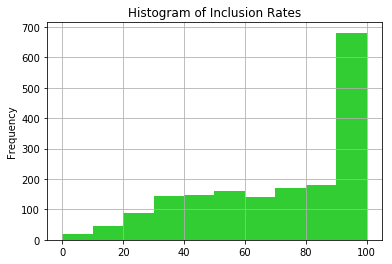

-- Mean inclusion rate 71.95947516930025
-- Median inclusion rate 78.18
--------------------------

For each predicted paragraph, how much of it is extra content not in the test paragraph?


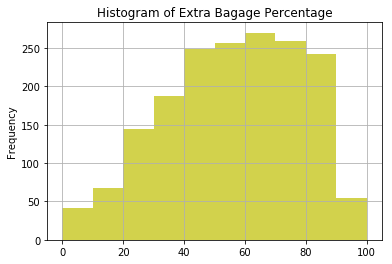

-- mean bagage rate:  56.12998306997744
-- median bagage rate:  57.82
----------------

What is the distribution of lengths of the word tokenized test paragraphs.


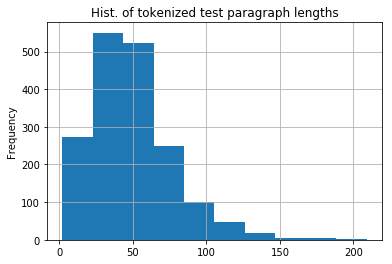

-- Mean tokenized test paragraph length  49.715011286681715
-- Median tokenized test paragraph length 46.0
-- Range of tokenized test paragraph lengths 207.0
------------------------------

What is the distribution of lengths of the word tokenized test paragraphs.


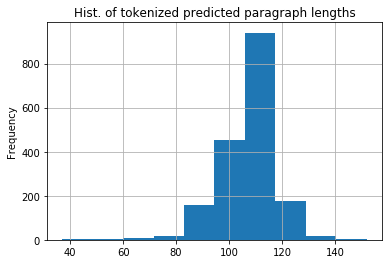

-- mean tokenized predicted parag. lenghts 107.33521444695259
-- median tokenized predicted parag. lenghts 108.0
-- range of tokenized predicted parag. lenghts 115
------------------------------



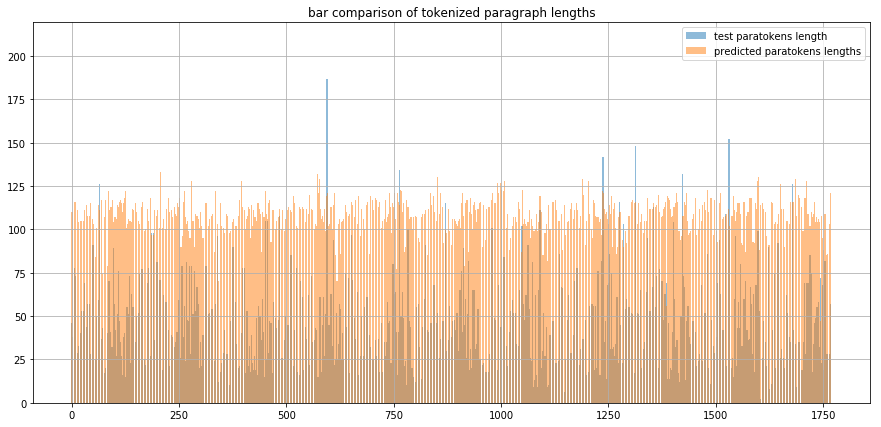

In [16]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test paragraph, how many of them are 100% included in the predicted paragraph?")
print(round(100*(share_rprchs_prgrph_df.tot_incl.sum())/len(share_rprchs_prgrph_df.tot_incl), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
#plt.hist(share_rprchs_prgrph_df.inclusion_pct, bins=20)
print('For each test paragraph, how much of it is included in the corresponding predicted paragraph?')
share_rprchs_prgrph_df.inclusion_pct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.inclusion_pct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.inclusion_pct.median())
print("--------------------------")
print("")

# report extra baggage rate
#plt.hist(share_rprchs_prgrph_df.baggage_pct)
print('For each predicted paragraph, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.baggage_pct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.baggage_pct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.baggage_pct.median())
print("----------------")
print("")

# report lengths of tokenized paragraphs
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_tst_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized test paragraph lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test paragraph length ', np.mean(share_rprchs_prgrph_df.tknzd_tst_par_len))
print('-- Median tokenized test paragraph length', share_rprchs_prgrph_df.tknzd_tst_par_len.median())
print('-- Range of tokenized test paragraph lengths', np.max(share_rprchs_prgrph_df.tknzd_tst_par_len) - np.min(share_rprchs_prgrph_df.tknzd_tst_par_len))
print("-"*30)
print("")

#plt.hist(share_rprchs_prgrph_df.tknzd_pred_par_len)
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_pred_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted paragraph lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted parag. lenghts', np.mean(share_rprchs_prgrph_df.tknzd_pred_par_len))
print('-- median tokenized predicted parag. lenghts', share_rprchs_prgrph_df.tknzd_pred_par_len.median())
print('-- range of tokenized predicted parag. lenghts', (np.max(share_rprchs_prgrph_df.tknzd_pred_par_len)) - np.min(share_rprchs_prgrph_df.tknzd_pred_par_len))
print("-"*30)
print("")
# plot overlay of each paragraph's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
        #x = range(len(share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(value = np.nan))))
plt.bar(height = share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
       #x = range(len(share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(value = np.nan))))
plt.title('bar comparison of tokenized paragraph lengths')
plt.legend(['test paratokens length', 'predicted paratokens lengths'])
plt.grid()
plt.show()

### fit and train a df['text'] classification model for each dkfn

In [17]:
# split data into train, fit and test subsets
X_train, X_test, y_train_ix, y_test_ix = train_test_split(share_rprchs_prgrph_df.text,
                                                   share_rprchs_prgrph_df.index, ### Watchout this is just a placeholder for now
                                                   test_size = 0.33,
                                                   random_state = 53)
# initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

In [18]:
# transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [19]:
# make and fit a model for each dkfn
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'][[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Horizontally Validate the seven models**

In [20]:
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

80.3 % amount accuracy
79.0 % authorization accuracy
84.6 % count accuracy
76.9 % date accuracy
86.3 % intention accuracy
93.2 % unknown accuracy
97.8 % utilization accuracy


### Define the dkfn slices
for each dkfn filter the data frame by that dkfn

In [21]:
unk_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Unknown Share Repurchase Data']
#unk_df.info()

In [22]:
util_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Utilization']
#util_df.info()

In [23]:
shrp_intent_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Intention']
#shrp_intent_df.info()

In [24]:
shrp_count_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Count']
#shrp_count_df.info()

In [25]:
auth_dt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization Date']
#auth_dt_df.info()

In [26]:
auth_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization']
#auth_df.info()

In [27]:
amnt_spnt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Amount Spent on Share Repurchases']
#amnt_spnt_df.info()

In [28]:
# spot check that the text column is only strings
for c in share_rprchs_prgrph_df.text:
    assert(type('str') == type(c))

In [29]:
dkfn_slices = [unk_df, util_df, shrp_count_df, shrp_intent_df, 
               auth_df, auth_dt_df, amnt_spnt_df]

In [30]:
type(dkfn_slices[0])

pandas.core.frame.DataFrame

## generate key_tokens for each dkfn
store key_tokens and models in dictionaries for later use

In [31]:
## use dictionary to assign models in loop
models_dict ={}
for mdl, k in zip(models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    models_dict['{0}'.format(k)] = mdl


In [32]:
# use dictionary to assign variables in loop:
dkfn_kts_dict = {}
for slc, k in zip(dkfn_slices, 
                  ['unk_kts', 'util_kts', 'count_kts', 'intent_kts', 'auth_kts', 'date_kts', 'spent_kts']):
    dkfn_kts_dict['{0}'.format(k)] = get_relevant_key_word_tokens(slc.text)
    
#print(dkfn_kts_dict)

In [33]:
dkfn_kts_dict['unk_kts']

,key_tok,kt_count
0,repurchase,74
1,board,54
2,authorized,52
3,directors,49
4,program,31
5,shares,25
6,company,24
7,authorization,18
8,share,15
9,approved,12


### stage filings to be iteratively read in

In [34]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

In [35]:
len(training_filings_list)

435

In [36]:
round(160/len(training_filings_list),2)*100

37.0

### stage test filings

In [37]:
# initialize a list of paths
validation_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_validation_filings/'):
    validation_filings_list += glob.glob(os.path.join(root, '*.html'))
print(training_filings_list[0:3])

['data/nc_training_filings/0001193125-17-248016.html', 'data/nc_training_filings/0000318154-18-000004.html', 'data/nc_training_filings/0000769397-18-000011.html']


In [38]:
len(validation_filings_list)

100

# For each filing
## predict and vertically validate paragraph
Compare the predicted paragraph column to the test paragraph column
- don't run this again unless you want to wait about 2 hours to output anew the csv I previously wrote out and have now read in at the top this notebook

for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.pred_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a pragraph using that rows dkfn's margin and key toks
        nominees, string_filing = define_nominated_paragraphs(filing, key_tokens = key_tokens, margin = 600)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, string_filing, model = 'token_density', key_tokens=key_tokens, verbose = False, inverse= False)
        pred_par = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_par[i] = pred_par
        share_rprchs_prgrph_df.pred_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(pred_par, share_rprchs_prgrph_df.paragraph_text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.tot_incl[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.inclusion_pct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.baggage_pct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.tknzd_tst_par_len[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.tknzd_pred_par_len[i] = (results_dct['pred_tokenized_par_len'])
        

## initialize some storage columns for predicted text and pred_text validation metrics

In [39]:
share_rprchs_prgrph_df.columns

Index(['ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'pred_par', 'amount', 'authorization', 'date', 'count', 'intention',
       'utilization', 'unknown', 'pred_proba', 'tknzd_tst_par_len', 'tot_incl',
       'inclusion_pct', 'baggage_pct', 'tknzd_pred_par_len'],
      dtype='object')

In [40]:
share_rprchs_prgrph_df['pred_text'] = np.nan
share_rprchs_prgrph_df['predtext_proba'] = None
share_rprchs_prgrph_df['predtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_inclpct'] = np.nan
share_rprchs_prgrph_df['predtext_bggpct'] = np.nan
share_rprchs_prgrph_df['testtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_tknzdlen'] = np.nan
share_rprchs_prgrph_df['testtext_tknzdlen'] = np.nan

In [41]:
share_rprchs_prgrph_df.predtext_proba[0]

In [42]:
type(share_rprchs_prgrph_df.pred_text[0])

numpy.float64

In [43]:
np.nan == np.nan

False

## For each predicted paragraph/row
### predict and validate predicted text column with test text column

In [43]:
for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.predtext_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a text using that rows dkfn's margin and key toks
        nominees, par = define_nominated_texts(share_rprchs_prgrph_df.pred_par[i], key_tokens = key_tokens, margin = 12)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, par, model = model, key_tokens=key_tokens, vectorizer=tfidf_vectorizer, verbose = False, inverse= True)
        prd_txt = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_text[i] = prd_txt
        share_rprchs_prgrph_df.predtext_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(prd_txt, share_rprchs_prgrph_df.text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.predtext_totinc[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.predtext_inclpct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.predtext_bggpct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.testtext_tknzdlen[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.predtext_tknzdlen[i] = (results_dct['pred_tokenized_par_len'])
        

2018-06-09 19:16:41.358764 WORKING ON FILING 0 out of 435 0.0 % done.
2018-06-09 19:16:41.361031 -- working on RMD Unknown Share Repurchase Data
2018-06-09 19:16:41.361665 ------ using key_tokens for unk_kts
2018-06-09 19:16:41.365738 ------ using unk_model


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packa

2018-06-09 19:16:41.795392 ---------- wrote predicted paragraph. row took 0:00:00.436639
2018-06-09 19:16:41.808263 measured inclusion.
2018-06-09 19:16:42.097187 -- working on RMD Share Repurchase Authorization Date


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWar

2018-06-09 19:16:42.098264 ------ using key_tokens for date_kts
2018-06-09 19:16:42.100457 ------ using date_model
2018-06-09 19:16:42.211382 ---------- wrote predicted paragraph. row took 0:00:00.852623
2018-06-09 19:16:42.218697 measured inclusion.
2018-06-09 19:16:42.452193 -- working on RMD Unknown Share Repurchase Data
2018-06-09 19:16:42.452752 ------ using key_tokens for unk_kts
2018-06-09 19:16:42.454031 ------ using unk_model
2018-06-09 19:16:42.577024 ---------- wrote predicted paragraph. row took 0:00:01.218267
2018-06-09 19:16:42.582828 measured inclusion.
2018-06-09 19:16:42.817618 WORKING ON FILING 1 out of 435 0.22988505747126436 % done.
2018-06-09 19:16:42.819922 -- working on AMGN Share Repurchase Authorization Date
2018-06-09 19:16:42.820554 ------ using key_tokens for date_kts
2018-06-09 19:16:42.822828 ------ using date_model
2018-06-09 19:16:42.932904 ---------- wrote predicted paragraph. row took 0:00:00.115293
2018-06-09 19:16:42.937825 measured inclusion.
2018-0

2018-06-09 19:16:49.021617 -- working on RL Share Repurchase Count
2018-06-09 19:16:49.022917 ------ using key_tokens for count_kts
2018-06-09 19:16:49.023887 ------ using count_model
2018-06-09 19:16:49.120550 ---------- wrote predicted paragraph. row took 0:00:01.435489
2018-06-09 19:16:49.124667 measured inclusion.
2018-06-09 19:16:49.326428 WORKING ON FILING 5 out of 435 1.1494252873563218 % done.
2018-06-09 19:16:49.328014 -- working on CAKE Share Repurchase Utilization
2018-06-09 19:16:49.328330 ------ using key_tokens for util_kts
2018-06-09 19:16:49.329467 ------ using util_model
2018-06-09 19:16:49.434330 ---------- wrote predicted paragraph. row took 0:00:00.107909
2018-06-09 19:16:49.437361 measured inclusion.
2018-06-09 19:16:49.697480 -- working on CAKE Share Repurchase Authorization Date
2018-06-09 19:16:49.698267 ------ using key_tokens for date_kts
2018-06-09 19:16:49.700197 ------ using date_model
2018-06-09 19:16:49.800153 ---------- wrote predicted paragraph. row too

2018-06-09 19:16:55.715330 -- working on STX Share Repurchase Count
2018-06-09 19:16:55.715941 ------ using key_tokens for count_kts
2018-06-09 19:16:55.716967 ------ using count_model
2018-06-09 19:16:55.831786 ---------- wrote predicted paragraph. row took 0:00:01.144235
2018-06-09 19:16:55.837651 measured inclusion.
2018-06-09 19:16:56.119910 -- working on STX Share Repurchase Authorization Date
2018-06-09 19:16:56.120791 ------ using key_tokens for date_kts
2018-06-09 19:16:56.121716 ------ using date_model
2018-06-09 19:16:56.226950 ---------- wrote predicted paragraph. row took 0:00:01.539398
2018-06-09 19:16:56.230352 measured inclusion.
2018-06-09 19:16:56.427326 WORKING ON FILING 11 out of 435 2.528735632183908 % done.
2018-06-09 19:16:56.428543 -- working on VIAB Share Repurchase Authorization
2018-06-09 19:16:56.429301 ------ using key_tokens for auth_kts
2018-06-09 19:16:56.430048 ------ using auth_model
2018-06-09 19:16:56.522534 ---------- wrote predicted paragraph. row t

2018-06-09 19:17:02.371782 -- working on MGM Share Repurchase Authorization
2018-06-09 19:17:02.372340 ------ using key_tokens for auth_kts
2018-06-09 19:17:02.373153 ------ using auth_model
2018-06-09 19:17:02.472512 ---------- wrote predicted paragraph. row took 0:00:01.138092
2018-06-09 19:17:02.477310 measured inclusion.
2018-06-09 19:17:02.682491 -- working on MGM Amount Spent on Share Repurchases
2018-06-09 19:17:02.683371 ------ using key_tokens for spent_kts
2018-06-09 19:17:02.684407 ------ using spent_model
2018-06-09 19:17:02.784722 ---------- wrote predicted paragraph. row took 0:00:01.450303
2018-06-09 19:17:02.789892 measured inclusion.
2018-06-09 19:17:03.026612 WORKING ON FILING 16 out of 435 3.67816091954023 % done.
2018-06-09 19:17:03.028142 -- working on AGN Share Repurchase Utilization
2018-06-09 19:17:03.028429 ------ using key_tokens for util_kts
2018-06-09 19:17:03.029298 ------ using util_model
2018-06-09 19:17:03.145829 ---------- wrote predicted paragraph. row

2018-06-09 19:17:09.383296 -- working on NLSN Share Repurchase Count
2018-06-09 19:17:09.383756 ------ using key_tokens for count_kts
2018-06-09 19:17:09.384689 ------ using count_model
2018-06-09 19:17:09.489737 ---------- wrote predicted paragraph. row took 0:00:01.902883
2018-06-09 19:17:09.492812 measured inclusion.
2018-06-09 19:17:09.727518 -- working on NLSN Share Repurchase Count
2018-06-09 19:17:09.728352 ------ using key_tokens for count_kts
2018-06-09 19:17:09.729284 ------ using count_model
2018-06-09 19:17:09.833039 ---------- wrote predicted paragraph. row took 0:00:02.246184
2018-06-09 19:17:09.836212 measured inclusion.
2018-06-09 19:17:10.061324 -- working on NLSN Share Repurchase Count
2018-06-09 19:17:10.061725 ------ using key_tokens for count_kts
2018-06-09 19:17:10.062620 ------ using count_model
2018-06-09 19:17:10.191420 ---------- wrote predicted paragraph. row took 0:00:02.604567
2018-06-09 19:17:10.195086 measured inclusion.
2018-06-09 19:17:10.438013 -- work

2018-06-09 19:17:16.721666 WORKING ON FILING 24 out of 435 5.517241379310345 % done.
2018-06-09 19:17:16.722932 -- working on CMG Share Repurchase Authorization Date
2018-06-09 19:17:16.723789 ------ using key_tokens for date_kts
2018-06-09 19:17:16.724612 ------ using date_model
2018-06-09 19:17:16.818683 ---------- wrote predicted paragraph. row took 0:00:00.097025
2018-06-09 19:17:16.824928 measured inclusion.
2018-06-09 19:17:17.028814 -- working on CMG Share Repurchase Count
2018-06-09 19:17:17.029589 ------ using key_tokens for count_kts
2018-06-09 19:17:17.030485 ------ using count_model
2018-06-09 19:17:17.126031 ---------- wrote predicted paragraph. row took 0:00:00.404373
2018-06-09 19:17:17.130347 measured inclusion.
2018-06-09 19:17:17.336166 -- working on CMG Amount Spent on Share Repurchases
2018-06-09 19:17:17.336885 ------ using key_tokens for spent_kts
2018-06-09 19:17:17.338266 ------ using spent_model
2018-06-09 19:17:17.446662 ---------- wrote predicted paragraph. r

2018-06-09 19:17:23.563088 -- working on UNM Amount Spent on Share Repurchases
2018-06-09 19:17:23.563973 ------ using key_tokens for spent_kts
2018-06-09 19:17:23.564762 ------ using spent_model
2018-06-09 19:17:23.676843 ---------- wrote predicted paragraph. row took 0:00:00.823040
2018-06-09 19:17:23.680695 measured inclusion.
2018-06-09 19:17:23.915957 -- working on UNM Share Repurchase Authorization
2018-06-09 19:17:23.916555 ------ using key_tokens for auth_kts
2018-06-09 19:17:23.917388 ------ using auth_model
2018-06-09 19:17:24.028802 ---------- wrote predicted paragraph. row took 0:00:01.174999
2018-06-09 19:17:24.031972 measured inclusion.
2018-06-09 19:17:24.262230 WORKING ON FILING 29 out of 435 6.666666666666667 % done.
2018-06-09 19:17:24.263482 -- working on SLB Share Repurchase Authorization Date
2018-06-09 19:17:24.264638 ------ using key_tokens for date_kts
2018-06-09 19:17:24.265742 ------ using date_model
2018-06-09 19:17:24.369242 ---------- wrote predicted paragr

2018-06-09 19:17:30.266515 -- working on TXT Share Repurchase Count
2018-06-09 19:17:30.266934 ------ using key_tokens for count_kts
2018-06-09 19:17:30.267974 ------ using count_model
2018-06-09 19:17:30.385344 ---------- wrote predicted paragraph. row took 0:00:00.468663
2018-06-09 19:17:30.389077 measured inclusion.
2018-06-09 19:17:30.616107 -- working on TXT Share Repurchase Authorization Date
2018-06-09 19:17:30.616808 ------ using key_tokens for date_kts
2018-06-09 19:17:30.617655 ------ using date_model
2018-06-09 19:17:30.718812 ---------- wrote predicted paragraph. row took 0:00:00.802131
2018-06-09 19:17:30.723248 measured inclusion.
2018-06-09 19:17:30.952865 -- working on TXT Unknown Share Repurchase Data
2018-06-09 19:17:30.953284 ------ using key_tokens for unk_kts
2018-06-09 19:17:30.954897 ------ using unk_model
2018-06-09 19:17:31.064127 ---------- wrote predicted paragraph. row took 0:00:01.147446
2018-06-09 19:17:31.069079 measured inclusion.
2018-06-09 19:17:31.294

2018-06-09 19:17:37.277845 WORKING ON FILING 40 out of 435 9.195402298850574 % done.
2018-06-09 19:17:37.279464 -- working on ADP Share Repurchase Count
2018-06-09 19:17:37.279991 ------ using key_tokens for count_kts
2018-06-09 19:17:37.281065 ------ using count_model
2018-06-09 19:17:37.409317 ---------- wrote predicted paragraph. row took 0:00:00.131479
2018-06-09 19:17:37.414261 measured inclusion.
2018-06-09 19:17:37.669007 -- working on ADP Unknown Share Repurchase Data
2018-06-09 19:17:37.670180 ------ using key_tokens for unk_kts
2018-06-09 19:17:37.671857 ------ using unk_model
2018-06-09 19:17:37.801142 ---------- wrote predicted paragraph. row took 0:00:00.523304
2018-06-09 19:17:37.805780 measured inclusion.
2018-06-09 19:17:38.041971 -- working on ADP Amount Spent on Share Repurchases
2018-06-09 19:17:38.042583 ------ using key_tokens for spent_kts
2018-06-09 19:17:38.043402 ------ using spent_model
2018-06-09 19:17:38.168582 ---------- wrote predicted paragraph. row took 

2018-06-09 19:17:44.067444 -- working on TROW Share Repurchase Authorization Date
2018-06-09 19:17:44.067972 ------ using key_tokens for date_kts
2018-06-09 19:17:44.068872 ------ using date_model
2018-06-09 19:17:44.157169 ---------- wrote predicted paragraph. row took 0:00:00.717447
2018-06-09 19:17:44.161047 measured inclusion.
2018-06-09 19:17:44.362332 WORKING ON FILING 45 out of 435 10.344827586206897 % done.
2018-06-09 19:17:44.363563 -- working on SWKS Share Repurchase Authorization Date
2018-06-09 19:17:44.364030 ------ using key_tokens for date_kts
2018-06-09 19:17:44.365220 ------ using date_model
2018-06-09 19:17:44.464939 ---------- wrote predicted paragraph. row took 0:00:00.102615
2018-06-09 19:17:44.470129 measured inclusion.
2018-06-09 19:17:44.669650 -- working on SWKS Amount Spent on Share Repurchases
2018-06-09 19:17:44.670163 ------ using key_tokens for spent_kts
2018-06-09 19:17:44.670870 ------ using spent_model
2018-06-09 19:17:44.774769 ---------- wrote predict

2018-06-09 19:17:50.434667 WORKING ON FILING 50 out of 435 11.494252873563218 % done.
2018-06-09 19:17:50.436755 -- working on HBI Unknown Share Repurchase Data
2018-06-09 19:17:50.437060 ------ using key_tokens for unk_kts
2018-06-09 19:17:50.438050 ------ using unk_model
2018-06-09 19:17:50.556504 ---------- wrote predicted paragraph. row took 0:00:00.121845
2018-06-09 19:17:50.564899 measured inclusion.
2018-06-09 19:17:50.836471 -- working on HBI Share Repurchase Authorization Date
2018-06-09 19:17:50.837533 ------ using key_tokens for date_kts
2018-06-09 19:17:50.843313 ------ using date_model
2018-06-09 19:17:50.960570 ---------- wrote predicted paragraph. row took 0:00:00.525910
2018-06-09 19:17:50.963948 measured inclusion.
2018-06-09 19:17:51.215268 -- working on HBI Share Repurchase Count
2018-06-09 19:17:51.215742 ------ using key_tokens for count_kts
2018-06-09 19:17:51.216703 ------ using count_model
2018-06-09 19:17:51.329623 ---------- wrote predicted paragraph. row took

2018-06-09 19:17:57.797370 -- working on CAH Amount Spent on Share Repurchases
2018-06-09 19:17:57.798066 ------ using key_tokens for spent_kts
2018-06-09 19:17:57.799352 ------ using spent_model
2018-06-09 19:17:57.904858 ---------- wrote predicted paragraph. row took 0:00:00.442297
2018-06-09 19:17:57.909164 measured inclusion.
2018-06-09 19:17:58.136176 -- working on CAH Share Repurchase Authorization Date
2018-06-09 19:17:58.136882 ------ using key_tokens for date_kts
2018-06-09 19:17:58.138398 ------ using date_model
2018-06-09 19:17:58.244439 ---------- wrote predicted paragraph. row took 0:00:00.781877
2018-06-09 19:17:58.247677 measured inclusion.
2018-06-09 19:17:58.472420 -- working on CAH Share Repurchase Intention
2018-06-09 19:17:58.472933 ------ using key_tokens for intent_kts
2018-06-09 19:17:58.473840 ------ using intent_model
2018-06-09 19:17:58.583872 ---------- wrote predicted paragraph. row took 0:00:01.121310
2018-06-09 19:17:58.590312 measured inclusion.
2018-06-0

2018-06-09 19:18:04.572092 -- working on EVHC Share Repurchase Intention
2018-06-09 19:18:04.572719 ------ using key_tokens for intent_kts
2018-06-09 19:18:04.574403 ------ using intent_model
2018-06-09 19:18:04.682664 ---------- wrote predicted paragraph. row took 0:00:01.153048
2018-06-09 19:18:04.689390 measured inclusion.
2018-06-09 19:18:04.915078 -- working on EVHC Share Repurchase Authorization
2018-06-09 19:18:04.915775 ------ using key_tokens for auth_kts
2018-06-09 19:18:04.916648 ------ using auth_model
2018-06-09 19:18:05.015287 ---------- wrote predicted paragraph. row took 0:00:01.485671
2018-06-09 19:18:05.023506 measured inclusion.
2018-06-09 19:18:05.243361 WORKING ON FILING 61 out of 435 14.022988505747126 % done.
2018-06-09 19:18:05.244663 -- working on VRTX Share Repurchase Authorization Date
2018-06-09 19:18:05.245291 ------ using key_tokens for date_kts
2018-06-09 19:18:05.246275 ------ using date_model
2018-06-09 19:18:05.348944 ---------- wrote predicted paragra

2018-06-09 19:18:11.047494 -- working on UPS Share Repurchase Intention
2018-06-09 19:18:11.048088 ------ using key_tokens for intent_kts
2018-06-09 19:18:11.049172 ------ using intent_model
2018-06-09 19:18:11.156983 ---------- wrote predicted paragraph. row took 0:00:00.789417
2018-06-09 19:18:11.161071 measured inclusion.
2018-06-09 19:18:11.388658 -- working on UPS Share Repurchase Count
2018-06-09 19:18:11.389076 ------ using key_tokens for count_kts
2018-06-09 19:18:11.389958 ------ using count_model
2018-06-09 19:18:11.494279 ---------- wrote predicted paragraph. row took 0:00:01.126714
2018-06-09 19:18:11.497811 measured inclusion.
2018-06-09 19:18:11.721970 -- working on UPS Amount Spent on Share Repurchases
2018-06-09 19:18:11.722691 ------ using key_tokens for spent_kts
2018-06-09 19:18:11.724032 ------ using spent_model
2018-06-09 19:18:11.832819 ---------- wrote predicted paragraph. row took 0:00:01.465254
2018-06-09 19:18:11.837807 measured inclusion.
2018-06-09 19:18:12.

2018-06-09 19:18:17.835772 -- working on MTD Share Repurchase Intention
2018-06-09 19:18:17.836259 ------ using key_tokens for intent_kts
2018-06-09 19:18:17.837209 ------ using intent_model
2018-06-09 19:18:17.949796 ---------- wrote predicted paragraph. row took 0:00:01.118895
2018-06-09 19:18:17.953170 measured inclusion.
2018-06-09 19:18:18.177867 -- working on MTD Share Repurchase Authorization Date
2018-06-09 19:18:18.178772 ------ using key_tokens for date_kts
2018-06-09 19:18:18.179613 ------ using date_model
2018-06-09 19:18:18.276640 ---------- wrote predicted paragraph. row took 0:00:01.445737
2018-06-09 19:18:18.279514 measured inclusion.
2018-06-09 19:18:18.495373 WORKING ON FILING 70 out of 435 16.091954022988507 % done.
2018-06-09 19:18:18.497192 -- working on HPE Amount Spent on Share Repurchases
2018-06-09 19:18:18.498300 ------ using key_tokens for spent_kts
2018-06-09 19:18:18.499393 ------ using spent_model
2018-06-09 19:18:18.616839 ---------- wrote predicted parag

2018-06-09 19:18:24.611685 -- working on PFE Share Repurchase Authorization
2018-06-09 19:18:24.612223 ------ using key_tokens for auth_kts
2018-06-09 19:18:24.613174 ------ using auth_model
2018-06-09 19:18:24.724053 ---------- wrote predicted paragraph. row took 0:00:01.125626
2018-06-09 19:18:24.726715 measured inclusion.
2018-06-09 19:18:24.954491 -- working on PFE Share Repurchase Authorization Date
2018-06-09 19:18:24.955139 ------ using key_tokens for date_kts
2018-06-09 19:18:24.955991 ------ using date_model
2018-06-09 19:18:25.057904 ---------- wrote predicted paragraph. row took 0:00:01.459478
2018-06-09 19:18:25.061851 measured inclusion.
2018-06-09 19:18:25.286081 -- working on PFE Share Repurchase Authorization
2018-06-09 19:18:25.286593 ------ using key_tokens for auth_kts
2018-06-09 19:18:25.287485 ------ using auth_model
2018-06-09 19:18:25.397597 ---------- wrote predicted paragraph. row took 0:00:01.799170
2018-06-09 19:18:25.400583 measured inclusion.
2018-06-09 19:

2018-06-09 19:18:31.425823 WORKING ON FILING 78 out of 435 17.93103448275862 % done.
2018-06-09 19:18:31.427428 -- working on CERN Share Repurchase Authorization Date
2018-06-09 19:18:31.427881 ------ using key_tokens for date_kts
2018-06-09 19:18:31.428694 ------ using date_model
2018-06-09 19:18:31.526731 ---------- wrote predicted paragraph. row took 0:00:00.100915
2018-06-09 19:18:31.530864 measured inclusion.
2018-06-09 19:18:31.757170 -- working on CERN Amount Spent on Share Repurchases
2018-06-09 19:18:31.757721 ------ using key_tokens for spent_kts
2018-06-09 19:18:31.758520 ------ using spent_model
2018-06-09 19:18:31.878866 ---------- wrote predicted paragraph. row took 0:00:00.453050
2018-06-09 19:18:31.882624 measured inclusion.
2018-06-09 19:18:32.110224 -- working on CERN Share Repurchase Count
2018-06-09 19:18:32.110629 ------ using key_tokens for count_kts
2018-06-09 19:18:32.111578 ------ using count_model
2018-06-09 19:18:32.217236 ---------- wrote predicted paragraph

2018-06-09 19:18:38.264323 -- working on DOV Amount Spent on Share Repurchases
2018-06-09 19:18:38.265340 ------ using key_tokens for spent_kts
2018-06-09 19:18:38.266576 ------ using spent_model
2018-06-09 19:18:38.380528 ---------- wrote predicted paragraph. row took 0:00:00.454647
2018-06-09 19:18:38.385020 measured inclusion.
2018-06-09 19:18:38.608957 WORKING ON FILING 84 out of 435 19.310344827586206 % done.
2018-06-09 19:18:38.610940 -- working on NOC Share Repurchase Intention
2018-06-09 19:18:38.612096 ------ using key_tokens for intent_kts
2018-06-09 19:18:38.613410 ------ using intent_model
2018-06-09 19:18:38.735363 ---------- wrote predicted paragraph. row took 0:00:00.126414
2018-06-09 19:18:38.740201 measured inclusion.
2018-06-09 19:18:38.969081 -- working on NOC Share Repurchase Authorization
2018-06-09 19:18:38.969593 ------ using key_tokens for auth_kts
2018-06-09 19:18:38.970469 ------ using auth_model
2018-06-09 19:18:39.083357 ---------- wrote predicted paragraph.

2018-06-09 19:18:45.233010 -- working on MSFT Share Repurchase Count
2018-06-09 19:18:45.233766 ------ using key_tokens for count_kts
2018-06-09 19:18:45.234982 ------ using count_model
2018-06-09 19:18:45.355648 ---------- wrote predicted paragraph. row took 0:00:01.185808
2018-06-09 19:18:45.359324 measured inclusion.
2018-06-09 19:18:45.591974 -- working on MSFT Share Repurchase Authorization Date
2018-06-09 19:18:45.592676 ------ using key_tokens for date_kts
2018-06-09 19:18:45.594203 ------ using date_model
2018-06-09 19:18:45.704327 ---------- wrote predicted paragraph. row took 0:00:01.534487
2018-06-09 19:18:45.708884 measured inclusion.
2018-06-09 19:18:45.948680 WORKING ON FILING 89 out of 435 20.45977011494253 % done.
2018-06-09 19:18:45.951055 -- working on PWR Share Repurchase Authorization Date
2018-06-09 19:18:45.951835 ------ using key_tokens for date_kts
2018-06-09 19:18:45.952686 ------ using date_model
2018-06-09 19:18:46.062436 ---------- wrote predicted paragraph.

2018-06-09 19:18:51.950705 WORKING ON FILING 94 out of 435 21.60919540229885 % done.
2018-06-09 19:18:51.954720 -- working on AAL Share Repurchase Authorization Date
2018-06-09 19:18:51.955483 ------ using key_tokens for date_kts
2018-06-09 19:18:51.956731 ------ using date_model
2018-06-09 19:18:52.055614 ---------- wrote predicted paragraph. row took 0:00:00.104915
2018-06-09 19:18:52.061827 measured inclusion.
2018-06-09 19:18:52.269169 -- working on AAL Share Repurchase Authorization
2018-06-09 19:18:52.269655 ------ using key_tokens for auth_kts
2018-06-09 19:18:52.270504 ------ using auth_model
2018-06-09 19:18:52.379765 ---------- wrote predicted paragraph. row took 0:00:00.429067
2018-06-09 19:18:52.384123 measured inclusion.
2018-06-09 19:18:52.602552 -- working on AAL Share Repurchase Intention
2018-06-09 19:18:52.603402 ------ using key_tokens for intent_kts
2018-06-09 19:18:52.604355 ------ using intent_model
2018-06-09 19:18:52.711983 ---------- wrote predicted paragraph. 

2018-06-09 19:18:58.998908 -- working on PYPL Amount Spent on Share Repurchases
2018-06-09 19:18:59.000094 ------ using key_tokens for spent_kts
2018-06-09 19:18:59.001478 ------ using spent_model
2018-06-09 19:18:59.134580 ---------- wrote predicted paragraph. row took 0:00:01.206045
2018-06-09 19:18:59.139269 measured inclusion.
2018-06-09 19:18:59.373356 -- working on PYPL Share Repurchase Authorization Date
2018-06-09 19:18:59.373934 ------ using key_tokens for date_kts
2018-06-09 19:18:59.374897 ------ using date_model
2018-06-09 19:18:59.482369 ---------- wrote predicted paragraph. row took 0:00:01.553835
2018-06-09 19:18:59.486249 measured inclusion.
2018-06-09 19:18:59.721862 WORKING ON FILING 99 out of 435 22.75862068965517 % done.
2018-06-09 19:18:59.723283 -- working on AFL Share Repurchase Authorization Date
2018-06-09 19:18:59.724248 ------ using key_tokens for date_kts
2018-06-09 19:18:59.725426 ------ using date_model
2018-06-09 19:18:59.830292 ---------- wrote predicted

2018-06-09 19:19:06.070555 -- working on LUV Share Repurchase Intention
2018-06-09 19:19:06.071080 ------ using key_tokens for intent_kts
2018-06-09 19:19:06.072111 ------ using intent_model
2018-06-09 19:19:06.191109 ---------- wrote predicted paragraph. row took 0:00:00.501590
2018-06-09 19:19:06.196591 measured inclusion.
2018-06-09 19:19:06.428062 -- working on LUV Share Repurchase Authorization Date
2018-06-09 19:19:06.429062 ------ using key_tokens for date_kts
2018-06-09 19:19:06.431057 ------ using date_model
2018-06-09 19:19:06.542528 ---------- wrote predicted paragraph. row took 0:00:00.853009
2018-06-09 19:19:06.548450 measured inclusion.
2018-06-09 19:19:06.775617 -- working on LUV Amount Spent on Share Repurchases
2018-06-09 19:19:06.776345 ------ using key_tokens for spent_kts
2018-06-09 19:19:06.778056 ------ using spent_model
2018-06-09 19:19:06.904220 ---------- wrote predicted paragraph. row took 0:00:01.214701
2018-06-09 19:19:06.909446 measured inclusion.
2018-06-0

2018-06-09 19:19:13.452732 -- working on CMCSA Share Repurchase Authorization Date
2018-06-09 19:19:13.453496 ------ using key_tokens for date_kts
2018-06-09 19:19:13.455334 ------ using date_model
2018-06-09 19:19:13.581871 ---------- wrote predicted paragraph. row took 0:00:01.173478
2018-06-09 19:19:13.586955 measured inclusion.
2018-06-09 19:19:13.828762 WORKING ON FILING 108 out of 435 24.82758620689655 % done.
2018-06-09 19:19:13.830882 -- working on ABBV Share Repurchase Count
2018-06-09 19:19:13.831736 ------ using key_tokens for count_kts
2018-06-09 19:19:13.832712 ------ using count_model
2018-06-09 19:19:13.971295 ---------- wrote predicted paragraph. row took 0:00:00.142539
2018-06-09 19:19:13.974898 measured inclusion.
2018-06-09 19:19:14.221158 -- working on ABBV Amount Spent on Share Repurchases
2018-06-09 19:19:14.221716 ------ using key_tokens for spent_kts
2018-06-09 19:19:14.222340 ------ using spent_model
2018-06-09 19:19:14.355182 ---------- wrote predicted paragra

2018-06-09 19:19:20.571079 -- working on MAR Share Repurchase Authorization Date
2018-06-09 19:19:20.571600 ------ using key_tokens for date_kts
2018-06-09 19:19:20.572526 ------ using date_model
2018-06-09 19:19:20.676780 ---------- wrote predicted paragraph. row took 0:00:01.160006
2018-06-09 19:19:20.680968 measured inclusion.
2018-06-09 19:19:20.908952 -- working on MAR Share Repurchase Count
2018-06-09 19:19:20.909395 ------ using key_tokens for count_kts
2018-06-09 19:19:20.910404 ------ using count_model
2018-06-09 19:19:21.022191 ---------- wrote predicted paragraph. row took 0:00:01.505416
2018-06-09 19:19:21.025863 measured inclusion.
2018-06-09 19:19:21.257806 -- working on MAR Unknown Share Repurchase Data
2018-06-09 19:19:21.258200 ------ using key_tokens for unk_kts
2018-06-09 19:19:21.259262 ------ using unk_model
2018-06-09 19:19:21.376285 ---------- wrote predicted paragraph. row took 0:00:01.859511
2018-06-09 19:19:21.380846 measured inclusion.
2018-06-09 19:19:21.616

2018-06-09 19:19:27.587446 -- working on ALGN Share Repurchase Authorization Date
2018-06-09 19:19:27.595272 ------ using key_tokens for date_kts
2018-06-09 19:19:27.599043 ------ using date_model
2018-06-09 19:19:27.702537 ---------- wrote predicted paragraph. row took 0:00:00.485934
2018-06-09 19:19:27.707239 measured inclusion.
2018-06-09 19:19:27.931577 -- working on ALGN Share Repurchase Authorization
2018-06-09 19:19:27.932100 ------ using key_tokens for auth_kts
2018-06-09 19:19:27.933037 ------ using auth_model
2018-06-09 19:19:28.040785 ---------- wrote predicted paragraph. row took 0:00:00.824182
2018-06-09 19:19:28.047203 measured inclusion.
2018-06-09 19:19:28.274732 -- working on ALGN Share Repurchase Intention
2018-06-09 19:19:28.275631 ------ using key_tokens for intent_kts
2018-06-09 19:19:28.276555 ------ using intent_model
2018-06-09 19:19:28.386749 ---------- wrote predicted paragraph. row took 0:00:01.170146
2018-06-09 19:19:28.391368 measured inclusion.
2018-06-09 

2018-06-09 19:19:34.893262 -- working on ICE Share Repurchase Authorization Date
2018-06-09 19:19:34.894061 ------ using key_tokens for date_kts
2018-06-09 19:19:34.894879 ------ using date_model
2018-06-09 19:19:35.004257 ---------- wrote predicted paragraph. row took 0:00:00.909158
2018-06-09 19:19:35.009964 measured inclusion.
2018-06-09 19:19:35.258208 -- working on ICE Amount Spent on Share Repurchases
2018-06-09 19:19:35.259754 ------ using key_tokens for spent_kts
2018-06-09 19:19:35.262149 ------ using spent_model
2018-06-09 19:19:35.389407 ---------- wrote predicted paragraph. row took 0:00:01.294309
2018-06-09 19:19:35.394418 measured inclusion.
2018-06-09 19:19:35.602082 WORKING ON FILING 123 out of 435 28.275862068965516 % done.
2018-06-09 19:19:35.603279 -- working on CPB Amount Spent on Share Repurchases
2018-06-09 19:19:35.604148 ------ using key_tokens for spent_kts
2018-06-09 19:19:35.604943 ------ using spent_model
2018-06-09 19:19:35.711023 ---------- wrote predicted

2018-06-09 19:19:41.997350 WORKING ON FILING 127 out of 435 29.195402298850574 % done.
2018-06-09 19:19:41.999078 -- working on AXP Share Repurchase Authorization Date
2018-06-09 19:19:41.999568 ------ using key_tokens for date_kts
2018-06-09 19:19:42.000357 ------ using date_model
2018-06-09 19:19:42.090673 ---------- wrote predicted paragraph. row took 0:00:00.093331
2018-06-09 19:19:42.097157 measured inclusion.
2018-06-09 19:19:42.327689 -- working on AXP Amount Spent on Share Repurchases
2018-06-09 19:19:42.329912 ------ using key_tokens for spent_kts
2018-06-09 19:19:42.334957 ------ using spent_model
2018-06-09 19:19:42.479150 ---------- wrote predicted paragraph. row took 0:00:00.481808
2018-06-09 19:19:42.485069 measured inclusion.
2018-06-09 19:19:42.709959 -- working on AXP Share Repurchase Count
2018-06-09 19:19:42.710332 ------ using key_tokens for count_kts
2018-06-09 19:19:42.711150 ------ using count_model
2018-06-09 19:19:42.809271 ---------- wrote predicted paragraph.

2018-06-09 19:19:48.925603 -- working on NVDA Share Repurchase Count
2018-06-09 19:19:48.926111 ------ using key_tokens for count_kts
2018-06-09 19:19:48.926859 ------ using count_model
2018-06-09 19:19:49.046334 ---------- wrote predicted paragraph. row took 0:00:00.432453
2018-06-09 19:19:49.050187 measured inclusion.
2018-06-09 19:19:49.322299 -- working on NVDA Share Repurchase Intention
2018-06-09 19:19:49.322939 ------ using key_tokens for intent_kts
2018-06-09 19:19:49.324435 ------ using intent_model
2018-06-09 19:19:49.463332 ---------- wrote predicted paragraph. row took 0:00:00.849452
2018-06-09 19:19:49.468312 measured inclusion.
2018-06-09 19:19:49.706048 -- working on NVDA Share Repurchase Authorization Date
2018-06-09 19:19:49.707499 ------ using key_tokens for date_kts
2018-06-09 19:19:49.708872 ------ using date_model
2018-06-09 19:19:49.808453 ---------- wrote predicted paragraph. row took 0:00:01.194571
2018-06-09 19:19:49.812078 measured inclusion.
2018-06-09 19:19:

2018-06-09 19:19:55.982170 -- working on YUM Share Repurchase Count
2018-06-09 19:19:55.983001 ------ using key_tokens for count_kts
2018-06-09 19:19:55.985073 ------ using count_model
2018-06-09 19:19:56.094160 ---------- wrote predicted paragraph. row took 0:00:01.190506
2018-06-09 19:19:56.098357 measured inclusion.
2018-06-09 19:19:56.305128 -- working on YUM Amount Spent on Share Repurchases
2018-06-09 19:19:56.305928 ------ using key_tokens for spent_kts
2018-06-09 19:19:56.307327 ------ using spent_model
2018-06-09 19:19:56.430822 ---------- wrote predicted paragraph. row took 0:00:01.527169
2018-06-09 19:19:56.436587 measured inclusion.
2018-06-09 19:19:56.694646 WORKING ON FILING 137 out of 435 31.49425287356322 % done.
2018-06-09 19:19:56.695809 -- working on COTY Share Repurchase Intention
2018-06-09 19:19:56.696411 ------ using key_tokens for intent_kts
2018-06-09 19:19:56.697376 ------ using intent_model
2018-06-09 19:19:56.796983 ---------- wrote predicted paragraph. row 

2018-06-09 19:20:02.875180 -- working on OXY Share Repurchase Authorization Date
2018-06-09 19:20:02.876780 ------ using key_tokens for date_kts
2018-06-09 19:20:02.878244 ------ using date_model
2018-06-09 19:20:02.966555 ---------- wrote predicted paragraph. row took 0:00:00.433840
2018-06-09 19:20:02.969864 measured inclusion.
2018-06-09 19:20:03.198719 WORKING ON FILING 142 out of 435 32.64367816091954 % done.
2018-06-09 19:20:03.200031 -- working on KSU Amount Spent on Share Repurchases
2018-06-09 19:20:03.200913 ------ using key_tokens for spent_kts
2018-06-09 19:20:03.201670 ------ using spent_model
2018-06-09 19:20:03.312383 ---------- wrote predicted paragraph. row took 0:00:00.113671
2018-06-09 19:20:03.315956 measured inclusion.
2018-06-09 19:20:03.541865 -- working on KSU Share Repurchase Authorization Date
2018-06-09 19:20:03.542472 ------ using key_tokens for date_kts
2018-06-09 19:20:03.543308 ------ using date_model
2018-06-09 19:20:03.644053 ---------- wrote predicted 

2018-06-09 19:20:09.868426 -- working on ALK Share Repurchase Authorization
2018-06-09 19:20:09.869118 ------ using key_tokens for auth_kts
2018-06-09 19:20:09.870669 ------ using auth_model
2018-06-09 19:20:09.988080 ---------- wrote predicted paragraph. row took 0:00:01.130227
2018-06-09 19:20:09.992226 measured inclusion.
2018-06-09 19:20:10.218231 -- working on ALK Share Repurchase Count
2018-06-09 19:20:10.218766 ------ using key_tokens for count_kts
2018-06-09 19:20:10.219691 ------ using count_model
2018-06-09 19:20:10.323528 ---------- wrote predicted paragraph. row took 0:00:01.465674
2018-06-09 19:20:10.327147 measured inclusion.
2018-06-09 19:20:10.556016 -- working on ALK Amount Spent on Share Repurchases
2018-06-09 19:20:10.556613 ------ using key_tokens for spent_kts
2018-06-09 19:20:10.557376 ------ using spent_model
2018-06-09 19:20:10.662980 ---------- wrote predicted paragraph. row took 0:00:01.805126
2018-06-09 19:20:10.666566 measured inclusion.
2018-06-09 19:20:10.

2018-06-09 19:20:18.835165 -- working on NUE Amount Spent on Share Repurchases
2018-06-09 19:20:18.836206 ------ using key_tokens for spent_kts
2018-06-09 19:20:18.837631 ------ using spent_model
2018-06-09 19:20:18.994821 ---------- wrote predicted paragraph. row took 0:00:02.527919
2018-06-09 19:20:18.999212 measured inclusion.
2018-06-09 19:20:19.272893 WORKING ON FILING 151 out of 435 34.71264367816092 % done.
2018-06-09 19:20:19.278813 -- working on WU Share Repurchase Authorization
2018-06-09 19:20:19.280762 ------ using key_tokens for auth_kts
2018-06-09 19:20:19.283236 ------ using auth_model
2018-06-09 19:20:19.421030 ---------- wrote predicted paragraph. row took 0:00:00.148145
2018-06-09 19:20:19.424686 measured inclusion.
2018-06-09 19:20:19.704914 -- working on WU Share Repurchase Count
2018-06-09 19:20:19.706852 ------ using key_tokens for count_kts
2018-06-09 19:20:19.708905 ------ using count_model
2018-06-09 19:20:19.844315 ---------- wrote predicted paragraph. row too

2018-06-09 19:20:25.913088 WORKING ON FILING 155 out of 435 35.632183908045974 % done.
2018-06-09 19:20:25.915387 -- working on EXPD Unknown Share Repurchase Data
2018-06-09 19:20:25.916143 ------ using key_tokens for unk_kts
2018-06-09 19:20:25.917916 ------ using unk_model
2018-06-09 19:20:26.023944 ---------- wrote predicted paragraph. row took 0:00:00.110863
2018-06-09 19:20:26.030335 measured inclusion.
2018-06-09 19:20:26.258334 -- working on EXPD Share Repurchase Authorization Date
2018-06-09 19:20:26.259282 ------ using key_tokens for date_kts
2018-06-09 19:20:26.260138 ------ using date_model
2018-06-09 19:20:26.361840 ---------- wrote predicted paragraph. row took 0:00:00.448760
2018-06-09 19:20:26.364691 measured inclusion.
2018-06-09 19:20:26.593830 -- working on EXPD Share Repurchase Count
2018-06-09 19:20:26.594332 ------ using key_tokens for count_kts
2018-06-09 19:20:26.595319 ------ using count_model
2018-06-09 19:20:26.711901 ---------- wrote predicted paragraph. row 

2018-06-09 19:20:33.453898 WORKING ON FILING 160 out of 435 36.7816091954023 % done.
2018-06-09 19:20:33.455446 -- working on LYB Share Repurchase Authorization Date
2018-06-09 19:20:33.456196 ------ using key_tokens for date_kts
2018-06-09 19:20:33.457021 ------ using date_model
2018-06-09 19:20:33.557332 ---------- wrote predicted paragraph. row took 0:00:00.103442
2018-06-09 19:20:33.560778 measured inclusion.
2018-06-09 19:20:33.782006 -- working on LYB Amount Spent on Share Repurchases
2018-06-09 19:20:33.782767 ------ using key_tokens for spent_kts
2018-06-09 19:20:33.784218 ------ using spent_model
2018-06-09 19:20:33.907384 ---------- wrote predicted paragraph. row took 0:00:00.453503
2018-06-09 19:20:33.916149 measured inclusion.
2018-06-09 19:20:34.128462 WORKING ON FILING 161 out of 435 37.01149425287356 % done.
2018-06-09 19:20:34.129828 -- working on LB Share Repurchase Intention
2018-06-09 19:20:34.130621 ------ using key_tokens for intent_kts
2018-06-09 19:20:34.131505 -

2018-06-09 19:20:40.830355 -- working on TRV Share Repurchase Authorization Date
2018-06-09 19:20:40.831200 ------ using key_tokens for date_kts
2018-06-09 19:20:40.832322 ------ using date_model
2018-06-09 19:20:40.952529 ---------- wrote predicted paragraph. row took 0:00:01.606750
2018-06-09 19:20:40.956828 measured inclusion.
2018-06-09 19:20:41.201146 WORKING ON FILING 166 out of 435 38.160919540229884 % done.
2018-06-09 19:20:41.202796 -- working on APD Share Repurchase Authorization Date
2018-06-09 19:20:41.203343 ------ using key_tokens for date_kts
2018-06-09 19:20:41.204124 ------ using date_model
2018-06-09 19:20:41.302303 ---------- wrote predicted paragraph. row took 0:00:00.101164
2018-06-09 19:20:41.310043 measured inclusion.
2018-06-09 19:20:41.539795 -- working on APD Share Repurchase Authorization
2018-06-09 19:20:41.540597 ------ using key_tokens for auth_kts
2018-06-09 19:20:41.541802 ------ using auth_model
2018-06-09 19:20:41.639494 ---------- wrote predicted para

2018-06-09 19:20:47.638095 -- working on DAL Share Repurchase Authorization Date
2018-06-09 19:20:47.639231 ------ using key_tokens for date_kts
2018-06-09 19:20:47.640820 ------ using date_model
2018-06-09 19:20:47.795346 ---------- wrote predicted paragraph. row took 0:00:00.530416
2018-06-09 19:20:47.799816 measured inclusion.
2018-06-09 19:20:48.067879 -- working on DAL Amount Spent on Share Repurchases
2018-06-09 19:20:48.068634 ------ using key_tokens for spent_kts
2018-06-09 19:20:48.069929 ------ using spent_model
2018-06-09 19:20:48.194997 ---------- wrote predicted paragraph. row took 0:00:00.930067
2018-06-09 19:20:48.200406 measured inclusion.
2018-06-09 19:20:48.452483 -- working on DAL Share Repurchase Count
2018-06-09 19:20:48.452964 ------ using key_tokens for count_kts
2018-06-09 19:20:48.453979 ------ using count_model
2018-06-09 19:20:48.602002 ---------- wrote predicted paragraph. row took 0:00:01.337072
2018-06-09 19:20:48.607699 measured inclusion.
2018-06-09 19:2

2018-06-09 19:20:55.205940 -- working on DRE Share Repurchase Authorization Date
2018-06-09 19:20:55.207167 ------ using key_tokens for date_kts
2018-06-09 19:20:55.208465 ------ using date_model
2018-06-09 19:20:55.320636 ---------- wrote predicted paragraph. row took 0:00:00.499575
2018-06-09 19:20:55.328095 measured inclusion.
2018-06-09 19:20:55.596830 -- working on DRE Share Repurchase Intention
2018-06-09 19:20:55.597470 ------ using key_tokens for intent_kts
2018-06-09 19:20:55.598419 ------ using intent_model
2018-06-09 19:20:55.733494 ---------- wrote predicted paragraph. row took 0:00:00.912434
2018-06-09 19:20:55.739727 measured inclusion.
2018-06-09 19:20:56.002934 WORKING ON FILING 178 out of 435 40.91954022988506 % done.
2018-06-09 19:20:56.008670 -- working on KMB Unknown Share Repurchase Data
2018-06-09 19:20:56.009430 ------ using key_tokens for unk_kts
2018-06-09 19:20:56.010411 ------ using unk_model
2018-06-09 19:20:56.149141 ---------- wrote predicted paragraph. ro

2018-06-09 19:21:02.272113 WORKING ON FILING 182 out of 435 41.839080459770116 % done.
2018-06-09 19:21:02.273830 -- working on AET Amount Spent on Share Repurchases
2018-06-09 19:21:02.274318 ------ using key_tokens for spent_kts
2018-06-09 19:21:02.275095 ------ using spent_model
2018-06-09 19:21:02.383161 ---------- wrote predicted paragraph. row took 0:00:00.111056
2018-06-09 19:21:02.386789 measured inclusion.
2018-06-09 19:21:02.611408 -- working on AET Share Repurchase Authorization Date
2018-06-09 19:21:02.612065 ------ using key_tokens for date_kts
2018-06-09 19:21:02.613171 ------ using date_model
2018-06-09 19:21:02.718690 ---------- wrote predicted paragraph. row took 0:00:00.446584
2018-06-09 19:21:02.724200 measured inclusion.
2018-06-09 19:21:02.952889 -- working on AET Share Repurchase Count
2018-06-09 19:21:02.953351 ------ using key_tokens for count_kts
2018-06-09 19:21:02.954270 ------ using count_model
2018-06-09 19:21:03.059017 ---------- wrote predicted paragraph.

2018-06-09 19:21:08.744716 -- working on DIS Unknown Share Repurchase Data
2018-06-09 19:21:08.745141 ------ using key_tokens for unk_kts
2018-06-09 19:21:08.746173 ------ using unk_model
2018-06-09 19:21:08.841917 ---------- wrote predicted paragraph. row took 0:00:01.120137
2018-06-09 19:21:08.846292 measured inclusion.
2018-06-09 19:21:09.067007 -- working on DIS Share Repurchase Count
2018-06-09 19:21:09.067632 ------ using key_tokens for count_kts
2018-06-09 19:21:09.068575 ------ using count_model
2018-06-09 19:21:09.183374 ---------- wrote predicted paragraph. row took 0:00:01.461595
2018-06-09 19:21:09.186751 measured inclusion.
2018-06-09 19:21:09.389876 WORKING ON FILING 188 out of 435 43.2183908045977 % done.
2018-06-09 19:21:09.391118 -- working on HII Amount Spent on Share Repurchases
2018-06-09 19:21:09.391652 ------ using key_tokens for spent_kts
2018-06-09 19:21:09.392373 ------ using spent_model
2018-06-09 19:21:09.487764 ---------- wrote predicted paragraph. row took 

2018-06-09 19:21:15.436199 -- working on IP Share Repurchase Authorization
2018-06-09 19:21:15.436975 ------ using key_tokens for auth_kts
2018-06-09 19:21:15.440132 ------ using auth_model
2018-06-09 19:21:15.575235 ---------- wrote predicted paragraph. row took 0:00:00.795657
2018-06-09 19:21:15.584195 measured inclusion.
2018-06-09 19:21:15.840017 -- working on IP Share Repurchase Intention
2018-06-09 19:21:15.840587 ------ using key_tokens for intent_kts
2018-06-09 19:21:15.842003 ------ using intent_model
2018-06-09 19:21:15.971649 ---------- wrote predicted paragraph. row took 0:00:01.192073
2018-06-09 19:21:15.976892 measured inclusion.
2018-06-09 19:21:16.228917 WORKING ON FILING 194 out of 435 44.59770114942529 % done.
2018-06-09 19:21:16.231370 -- working on COST Share Repurchase Authorization
2018-06-09 19:21:16.232171 ------ using key_tokens for auth_kts
2018-06-09 19:21:16.233600 ------ using auth_model
2018-06-09 19:21:16.367932 ---------- wrote predicted paragraph. row t

2018-06-09 19:21:22.794740 -- working on ROST Share Repurchase Authorization Date
2018-06-09 19:21:22.797062 ------ using key_tokens for date_kts
2018-06-09 19:21:22.798433 ------ using date_model
2018-06-09 19:21:22.911685 ---------- wrote predicted paragraph. row took 0:00:00.487369
2018-06-09 19:21:22.915624 measured inclusion.
2018-06-09 19:21:23.124037 -- working on ROST Amount Spent on Share Repurchases
2018-06-09 19:21:23.124608 ------ using key_tokens for spent_kts
2018-06-09 19:21:23.125327 ------ using spent_model
2018-06-09 19:21:23.221936 ---------- wrote predicted paragraph. row took 0:00:00.797620
2018-06-09 19:21:23.225513 measured inclusion.
2018-06-09 19:21:23.447913 -- working on ROST Share Repurchase Count
2018-06-09 19:21:23.448420 ------ using key_tokens for count_kts
2018-06-09 19:21:23.449363 ------ using count_model
2018-06-09 19:21:23.568660 ---------- wrote predicted paragraph. row took 0:00:01.144345
2018-06-09 19:21:23.573393 measured inclusion.
2018-06-09 1

2018-06-09 19:21:30.010247 -- working on SLG Share Repurchase Authorization
2018-06-09 19:21:30.013694 ------ using key_tokens for auth_kts
2018-06-09 19:21:30.015449 ------ using auth_model
2018-06-09 19:21:30.141971 ---------- wrote predicted paragraph. row took 0:00:01.282344
2018-06-09 19:21:30.145740 measured inclusion.
2018-06-09 19:21:30.351355 -- working on SLG Share Repurchase Count
2018-06-09 19:21:30.351805 ------ using key_tokens for count_kts
2018-06-09 19:21:30.352596 ------ using count_model
2018-06-09 19:21:30.468139 ---------- wrote predicted paragraph. row took 0:00:01.608513
2018-06-09 19:21:30.472013 measured inclusion.
2018-06-09 19:21:30.710206 WORKING ON FILING 204 out of 435 46.89655172413793 % done.
2018-06-09 19:21:30.712174 -- working on PSX Share Repurchase Intention
2018-06-09 19:21:30.712850 ------ using key_tokens for intent_kts
2018-06-09 19:21:30.714237 ------ using intent_model
2018-06-09 19:21:30.814465 ---------- wrote predicted paragraph. row took 0

2018-06-09 19:21:36.555467 -- working on APTV Share Repurchase Intention
2018-06-09 19:21:36.555992 ------ using key_tokens for intent_kts
2018-06-09 19:21:36.557592 ------ using intent_model
2018-06-09 19:21:36.722772 ---------- wrote predicted paragraph. row took 0:00:01.211936
2018-06-09 19:21:36.730416 measured inclusion.
2018-06-09 19:21:36.936738 WORKING ON FILING 208 out of 435 47.81609195402299 % done.
2018-06-09 19:21:36.938285 -- working on FLIR Share Repurchase Authorization Date
2018-06-09 19:21:36.938816 ------ using key_tokens for date_kts
2018-06-09 19:21:36.939641 ------ using date_model
2018-06-09 19:21:37.033439 ---------- wrote predicted paragraph. row took 0:00:00.096708
2018-06-09 19:21:37.037128 measured inclusion.
2018-06-09 19:21:37.238861 -- working on FLIR Unknown Share Repurchase Data
2018-06-09 19:21:37.239294 ------ using key_tokens for unk_kts
2018-06-09 19:21:37.240340 ------ using unk_model
2018-06-09 19:21:37.357591 ---------- wrote predicted paragraph.

2018-06-09 19:21:43.083177 -- working on PVH Share Repurchase Authorization Date
2018-06-09 19:21:43.083784 ------ using key_tokens for date_kts
2018-06-09 19:21:43.084660 ------ using date_model
2018-06-09 19:21:43.184057 ---------- wrote predicted paragraph. row took 0:00:00.446573
2018-06-09 19:21:43.188278 measured inclusion.
2018-06-09 19:21:43.412772 -- working on PVH Share Repurchase Authorization
2018-06-09 19:21:43.413356 ------ using key_tokens for auth_kts
2018-06-09 19:21:43.414220 ------ using auth_model
2018-06-09 19:21:43.531508 ---------- wrote predicted paragraph. row took 0:00:00.794026
2018-06-09 19:21:43.535742 measured inclusion.
2018-06-09 19:21:43.766387 -- working on PVH Share Repurchase Authorization
2018-06-09 19:21:43.767525 ------ using key_tokens for auth_kts
2018-06-09 19:21:43.768809 ------ using auth_model
2018-06-09 19:21:43.882594 ---------- wrote predicted paragraph. row took 0:00:01.145110
2018-06-09 19:21:43.886543 measured inclusion.
2018-06-09 19:

2018-06-09 19:21:50.133662 WORKING ON FILING 218 out of 435 50.11494252873563 % done.
2018-06-09 19:21:50.134962 -- working on MAS Share Repurchase Count
2018-06-09 19:21:50.135889 ------ using key_tokens for count_kts
2018-06-09 19:21:50.136814 ------ using count_model
2018-06-09 19:21:50.250264 ---------- wrote predicted paragraph. row took 0:00:00.116610
2018-06-09 19:21:50.253855 measured inclusion.
2018-06-09 19:21:50.482607 -- working on MAS Share Repurchase Authorization
2018-06-09 19:21:50.483115 ------ using key_tokens for auth_kts
2018-06-09 19:21:50.483983 ------ using auth_model
2018-06-09 19:21:50.592065 ---------- wrote predicted paragraph. row took 0:00:00.458411
2018-06-09 19:21:50.598282 measured inclusion.
2018-06-09 19:21:50.826775 -- working on MAS Share Repurchase Authorization Date
2018-06-09 19:21:50.828043 ------ using key_tokens for date_kts
2018-06-09 19:21:50.829028 ------ using date_model
2018-06-09 19:21:50.929221 ---------- wrote predicted paragraph. row t

2018-06-09 19:21:56.647538 -- working on SIG Share Repurchase Authorization Date
2018-06-09 19:21:56.648442 ------ using key_tokens for date_kts
2018-06-09 19:21:56.649274 ------ using date_model
2018-06-09 19:21:56.737044 ---------- wrote predicted paragraph. row took 0:00:00.970912
2018-06-09 19:21:56.741347 measured inclusion.
2018-06-09 19:21:56.940363 WORKING ON FILING 223 out of 435 51.264367816091955 % done.
2018-06-09 19:21:56.941671 -- working on INFO Share Repurchase Count
2018-06-09 19:21:56.942030 ------ using key_tokens for count_kts
2018-06-09 19:21:56.942887 ------ using count_model
2018-06-09 19:21:57.032735 ---------- wrote predicted paragraph. row took 0:00:00.092379
2018-06-09 19:21:57.036126 measured inclusion.
2018-06-09 19:21:57.236457 -- working on INFO Share Repurchase Count
2018-06-09 19:21:57.236881 ------ using key_tokens for count_kts
2018-06-09 19:21:57.237771 ------ using count_model
2018-06-09 19:21:57.327917 ---------- wrote predicted paragraph. row took

2018-06-09 19:22:03.587109 -- working on BBY Share Repurchase Count
2018-06-09 19:22:03.587945 ------ using key_tokens for count_kts
2018-06-09 19:22:03.588944 ------ using count_model
2018-06-09 19:22:03.729306 ---------- wrote predicted paragraph. row took 0:00:01.306775
2018-06-09 19:22:03.732785 measured inclusion.
2018-06-09 19:22:03.953545 WORKING ON FILING 228 out of 435 52.41379310344828 % done.
2018-06-09 19:22:03.954774 -- working on MKC Amount Spent on Share Repurchases
2018-06-09 19:22:03.955329 ------ using key_tokens for spent_kts
2018-06-09 19:22:03.956020 ------ using spent_model
2018-06-09 19:22:04.077255 ---------- wrote predicted paragraph. row took 0:00:00.123717
2018-06-09 19:22:04.083774 measured inclusion.
2018-06-09 19:22:04.345866 -- working on MKC Share Repurchase Intention
2018-06-09 19:22:04.346817 ------ using key_tokens for intent_kts
2018-06-09 19:22:04.347711 ------ using intent_model
2018-06-09 19:22:04.443537 ---------- wrote predicted paragraph. row t

2018-06-09 19:22:10.861426 -- working on RHT Share Repurchase Authorization Date
2018-06-09 19:22:10.862622 ------ using key_tokens for date_kts
2018-06-09 19:22:10.863519 ------ using date_model
2018-06-09 19:22:10.971815 ---------- wrote predicted paragraph. row took 0:00:00.860859
2018-06-09 19:22:10.976373 measured inclusion.
2018-06-09 19:22:11.205648 -- working on RHT Share Repurchase Authorization
2018-06-09 19:22:11.206175 ------ using key_tokens for auth_kts
2018-06-09 19:22:11.207048 ------ using auth_model
2018-06-09 19:22:11.321092 ---------- wrote predicted paragraph. row took 0:00:01.210137
2018-06-09 19:22:11.327333 measured inclusion.
2018-06-09 19:22:11.553460 WORKING ON FILING 233 out of 435 53.5632183908046 % done.
2018-06-09 19:22:11.554803 -- working on COL Share Repurchase Authorization
2018-06-09 19:22:11.555347 ------ using key_tokens for auth_kts
2018-06-09 19:22:11.556469 ------ using auth_model
2018-06-09 19:22:11.668583 ---------- wrote predicted paragraph. 

2018-06-09 19:22:17.871272 -- working on AME Share Repurchase Authorization
2018-06-09 19:22:17.872146 ------ using key_tokens for auth_kts
2018-06-09 19:22:17.875130 ------ using auth_model
2018-06-09 19:22:18.011261 ---------- wrote predicted paragraph. row took 0:00:01.240773
2018-06-09 19:22:18.016782 measured inclusion.
2018-06-09 19:22:18.248565 WORKING ON FILING 238 out of 435 54.71264367816092 % done.
2018-06-09 19:22:18.249841 -- working on LH Share Repurchase Count
2018-06-09 19:22:18.250181 ------ using key_tokens for count_kts
2018-06-09 19:22:18.251346 ------ using count_model
2018-06-09 19:22:18.365530 ---------- wrote predicted paragraph. row took 0:00:00.116973
2018-06-09 19:22:18.369087 measured inclusion.
2018-06-09 19:22:18.596488 -- working on LH Amount Spent on Share Repurchases
2018-06-09 19:22:18.597491 ------ using key_tokens for spent_kts
2018-06-09 19:22:18.598253 ------ using spent_model
2018-06-09 19:22:18.703702 ---------- wrote predicted paragraph. row too

2018-06-09 19:22:24.667126 -- working on PAYX Share Repurchase Intention
2018-06-09 19:22:24.667652 ------ using key_tokens for intent_kts
2018-06-09 19:22:24.668578 ------ using intent_model
2018-06-09 19:22:24.771618 ---------- wrote predicted paragraph. row took 0:00:01.386892
2018-06-09 19:22:24.780180 measured inclusion.
2018-06-09 19:22:24.979088 WORKING ON FILING 243 out of 435 55.86206896551724 % done.
2018-06-09 19:22:24.980663 -- working on CAG Share Repurchase Count
2018-06-09 19:22:24.981358 ------ using key_tokens for count_kts
2018-06-09 19:22:24.982662 ------ using count_model
2018-06-09 19:22:25.081959 ---------- wrote predicted paragraph. row took 0:00:00.102878
2018-06-09 19:22:25.085326 measured inclusion.
2018-06-09 19:22:25.286044 -- working on CAG Amount Spent on Share Repurchases
2018-06-09 19:22:25.286550 ------ using key_tokens for spent_kts
2018-06-09 19:22:25.287312 ------ using spent_model
2018-06-09 19:22:25.387225 ---------- wrote predicted paragraph. row 

2018-06-09 19:22:30.748333 -- working on V Share Repurchase Authorization Date
2018-06-09 19:22:30.749071 ------ using key_tokens for date_kts
2018-06-09 19:22:30.750424 ------ using date_model
2018-06-09 19:22:30.841223 ---------- wrote predicted paragraph. row took 0:00:00.402993
2018-06-09 19:22:30.845379 measured inclusion.
2018-06-09 19:22:31.042626 -- working on V Share Repurchase Authorization
2018-06-09 19:22:31.043394 ------ using key_tokens for auth_kts
2018-06-09 19:22:31.044214 ------ using auth_model
2018-06-09 19:22:31.133444 ---------- wrote predicted paragraph. row took 0:00:00.695215
2018-06-09 19:22:31.137230 measured inclusion.
2018-06-09 19:22:31.336431 -- working on V Share Repurchase Intention
2018-06-09 19:22:31.337399 ------ using key_tokens for intent_kts
2018-06-09 19:22:31.338278 ------ using intent_model
2018-06-09 19:22:31.424606 ---------- wrote predicted paragraph. row took 0:00:00.986377
2018-06-09 19:22:31.428447 measured inclusion.
2018-06-09 19:22:31.

2018-06-09 19:22:36.785490 -- working on BKNG Amount Spent on Share Repurchases
2018-06-09 19:22:36.786002 ------ using key_tokens for spent_kts
2018-06-09 19:22:36.786766 ------ using spent_model
2018-06-09 19:22:36.882997 ---------- wrote predicted paragraph. row took 0:00:01.938241
2018-06-09 19:22:36.887071 measured inclusion.
2018-06-09 19:22:37.083418 WORKING ON FILING 253 out of 435 58.160919540229884 % done.
2018-06-09 19:22:37.085052 -- working on LEN Unknown Share Repurchase Data
2018-06-09 19:22:37.085533 ------ using key_tokens for unk_kts
2018-06-09 19:22:37.086728 ------ using unk_model
2018-06-09 19:22:37.188297 ---------- wrote predicted paragraph. row took 0:00:00.104887
2018-06-09 19:22:37.193078 measured inclusion.
2018-06-09 19:22:37.387968 -- working on LEN Unknown Share Repurchase Data
2018-06-09 19:22:37.388681 ------ using key_tokens for unk_kts
2018-06-09 19:22:37.389729 ------ using unk_model
2018-06-09 19:22:37.487831 ---------- wrote predicted paragraph. row

2018-06-09 19:22:43.560508 -- working on CMI Share Repurchase Count
2018-06-09 19:22:43.561100 ------ using key_tokens for count_kts
2018-06-09 19:22:43.562601 ------ using count_model
2018-06-09 19:22:43.672663 ---------- wrote predicted paragraph. row took 0:00:00.453973
2018-06-09 19:22:43.676198 measured inclusion.
2018-06-09 19:22:43.913670 -- working on CMI Share Repurchase Authorization Date
2018-06-09 19:22:43.914501 ------ using key_tokens for date_kts
2018-06-09 19:22:43.915348 ------ using date_model
2018-06-09 19:22:44.016013 ---------- wrote predicted paragraph. row took 0:00:00.797323
2018-06-09 19:22:44.019424 measured inclusion.
2018-06-09 19:22:44.247113 -- working on CMI Share Repurchase Authorization
2018-06-09 19:22:44.247694 ------ using key_tokens for auth_kts
2018-06-09 19:22:44.248562 ------ using auth_model
2018-06-09 19:22:44.356152 ---------- wrote predicted paragraph. row took 0:00:01.137464
2018-06-09 19:22:44.361612 measured inclusion.
2018-06-09 19:22:44.

2018-06-09 19:22:50.447094 -- working on VMC Share Repurchase Count
2018-06-09 19:22:50.447617 ------ using key_tokens for count_kts
2018-06-09 19:22:50.448506 ------ using count_model
2018-06-09 19:22:50.549154 ---------- wrote predicted paragraph. row took 0:00:00.439249
2018-06-09 19:22:50.552356 measured inclusion.
2018-06-09 19:22:50.788383 -- working on VMC Amount Spent on Share Repurchases
2018-06-09 19:22:50.790297 ------ using key_tokens for spent_kts
2018-06-09 19:22:50.791608 ------ using spent_model
2018-06-09 19:22:50.896734 ---------- wrote predicted paragraph. row took 0:00:00.786831
2018-06-09 19:22:50.900493 measured inclusion.
2018-06-09 19:22:51.127896 WORKING ON FILING 263 out of 435 60.45977011494253 % done.
2018-06-09 19:22:51.129130 -- working on MAA Unknown Share Repurchase Data
2018-06-09 19:22:51.129414 ------ using key_tokens for unk_kts
2018-06-09 19:22:51.130397 ------ using unk_model
2018-06-09 19:22:51.245595 ---------- wrote predicted paragraph. row took

2018-06-09 19:22:57.041818 -- working on MNST Amount Spent on Share Repurchases
2018-06-09 19:22:57.042386 ------ using key_tokens for spent_kts
2018-06-09 19:22:57.043166 ------ using spent_model
2018-06-09 19:22:57.161557 ---------- wrote predicted paragraph. row took 0:00:00.455529
2018-06-09 19:22:57.166115 measured inclusion.
2018-06-09 19:22:57.441373 -- working on MNST Share Repurchase Count
2018-06-09 19:22:57.443192 ------ using key_tokens for count_kts
2018-06-09 19:22:57.444820 ------ using count_model
2018-06-09 19:22:57.541748 ---------- wrote predicted paragraph. row took 0:00:00.835699
2018-06-09 19:22:57.544622 measured inclusion.
2018-06-09 19:22:57.757688 -- working on MNST Share Repurchase Intention
2018-06-09 19:22:57.758148 ------ using key_tokens for intent_kts
2018-06-09 19:22:57.759101 ------ using intent_model
2018-06-09 19:22:57.858096 ---------- wrote predicted paragraph. row took 0:00:01.152049
2018-06-09 19:22:57.861993 measured inclusion.
2018-06-09 19:22:

2018-06-09 19:23:03.791248 -- working on STZ Share Repurchase Authorization Date
2018-06-09 19:23:03.792019 ------ using key_tokens for date_kts
2018-06-09 19:23:03.792892 ------ using date_model
2018-06-09 19:23:03.886103 ---------- wrote predicted paragraph. row took 0:00:00.433084
2018-06-09 19:23:03.890794 measured inclusion.
2018-06-09 19:23:04.106939 -- working on STZ Share Repurchase Authorization
2018-06-09 19:23:04.107444 ------ using key_tokens for auth_kts
2018-06-09 19:23:04.108274 ------ using auth_model
2018-06-09 19:23:04.211719 ---------- wrote predicted paragraph. row took 0:00:00.758701
2018-06-09 19:23:04.214639 measured inclusion.
2018-06-09 19:23:04.419819 -- working on STZ Amount Spent on Share Repurchases
2018-06-09 19:23:04.420364 ------ using key_tokens for spent_kts
2018-06-09 19:23:04.421108 ------ using spent_model
2018-06-09 19:23:04.520177 ---------- wrote predicted paragraph. row took 0:00:01.067159
2018-06-09 19:23:04.524054 measured inclusion.
2018-06-0

2018-06-09 19:23:10.090343 -- working on AYI Share Repurchase Authorization Date
2018-06-09 19:23:10.091035 ------ using key_tokens for date_kts
2018-06-09 19:23:10.092438 ------ using date_model
2018-06-09 19:23:10.177420 ---------- wrote predicted paragraph. row took 0:00:00.396539
2018-06-09 19:23:10.181663 measured inclusion.
2018-06-09 19:23:10.381864 -- working on AYI Share Repurchase Count
2018-06-09 19:23:10.382446 ------ using key_tokens for count_kts
2018-06-09 19:23:10.384035 ------ using count_model
2018-06-09 19:23:10.504018 ---------- wrote predicted paragraph. row took 0:00:00.723136
2018-06-09 19:23:10.507377 measured inclusion.
2018-06-09 19:23:10.709413 WORKING ON FILING 278 out of 435 63.9080459770115 % done.
2018-06-09 19:23:10.711042 -- working on LLY Share Repurchase Intention
2018-06-09 19:23:10.711727 ------ using key_tokens for intent_kts
2018-06-09 19:23:10.712630 ------ using intent_model
2018-06-09 19:23:10.822900 ---------- wrote predicted paragraph. row to

2018-06-09 19:23:16.154480 -- working on MCK Share Repurchase Authorization
2018-06-09 19:23:16.154955 ------ using key_tokens for auth_kts
2018-06-09 19:23:16.155793 ------ using auth_model
2018-06-09 19:23:16.251727 ---------- wrote predicted paragraph. row took 0:00:00.734918
2018-06-09 19:23:16.256600 measured inclusion.
2018-06-09 19:23:16.460225 -- working on MCK Share Repurchase Count
2018-06-09 19:23:16.460759 ------ using key_tokens for count_kts
2018-06-09 19:23:16.461698 ------ using count_model
2018-06-09 19:23:16.572723 ---------- wrote predicted paragraph. row took 0:00:01.055913
2018-06-09 19:23:16.576148 measured inclusion.
2018-06-09 19:23:16.777238 -- working on MCK Share Repurchase Authorization
2018-06-09 19:23:16.777727 ------ using key_tokens for auth_kts
2018-06-09 19:23:16.778732 ------ using auth_model
2018-06-09 19:23:16.883579 ---------- wrote predicted paragraph. row took 0:00:01.366769
2018-06-09 19:23:16.889185 measured inclusion.
2018-06-09 19:23:17.09813

2018-06-09 19:23:22.778313 WORKING ON FILING 286 out of 435 65.74712643678161 % done.
2018-06-09 19:23:22.781035 -- working on A Share Repurchase Authorization Date
2018-06-09 19:23:22.781767 ------ using key_tokens for date_kts
2018-06-09 19:23:22.783458 ------ using date_model
2018-06-09 19:23:22.889694 ---------- wrote predicted paragraph. row took 0:00:00.111392
2018-06-09 19:23:22.894584 measured inclusion.
2018-06-09 19:23:23.105110 -- working on A Share Repurchase Authorization
2018-06-09 19:23:23.105694 ------ using key_tokens for auth_kts
2018-06-09 19:23:23.106776 ------ using auth_model
2018-06-09 19:23:23.217300 ---------- wrote predicted paragraph. row took 0:00:00.438995
2018-06-09 19:23:23.223326 measured inclusion.
2018-06-09 19:23:23.450186 -- working on A Share Repurchase Intention
2018-06-09 19:23:23.450700 ------ using key_tokens for intent_kts
2018-06-09 19:23:23.451669 ------ using intent_model
2018-06-09 19:23:23.568414 ---------- wrote predicted paragraph. row t

2018-06-09 19:23:29.916438 -- working on IDXX Share Repurchase Count
2018-06-09 19:23:29.916927 ------ using key_tokens for count_kts
2018-06-09 19:23:29.917983 ------ using count_model
2018-06-09 19:23:30.060318 ---------- wrote predicted paragraph. row took 0:00:00.560535
2018-06-09 19:23:30.065958 measured inclusion.
2018-06-09 19:23:30.316647 -- working on IDXX Unknown Share Repurchase Data
2018-06-09 19:23:30.317177 ------ using key_tokens for unk_kts
2018-06-09 19:23:30.318556 ------ using unk_model
2018-06-09 19:23:30.433973 ---------- wrote predicted paragraph. row took 0:00:00.934190
2018-06-09 19:23:30.441450 measured inclusion.
2018-06-09 19:23:30.676902 WORKING ON FILING 291 out of 435 66.89655172413794 % done.
2018-06-09 19:23:30.678351 -- working on INTU Share Repurchase Authorization Date
2018-06-09 19:23:30.679014 ------ using key_tokens for date_kts
2018-06-09 19:23:30.680063 ------ using date_model
2018-06-09 19:23:30.789320 ---------- wrote predicted paragraph. row t

2018-06-09 19:23:37.301049 -- working on USB Share Repurchase Authorization Date
2018-06-09 19:23:37.301613 ------ using key_tokens for date_kts
2018-06-09 19:23:37.302484 ------ using date_model
2018-06-09 19:23:37.410997 ---------- wrote predicted paragraph. row took 0:00:00.481560
2018-06-09 19:23:37.415363 measured inclusion.
2018-06-09 19:23:37.663032 -- working on USB Share Repurchase Authorization
2018-06-09 19:23:37.664446 ------ using key_tokens for auth_kts
2018-06-09 19:23:37.666335 ------ using auth_model
2018-06-09 19:23:37.840998 ---------- wrote predicted paragraph. row took 0:00:00.911563
2018-06-09 19:23:37.850012 measured inclusion.
2018-06-09 19:23:38.127146 -- working on USB Share Repurchase Intention
2018-06-09 19:23:38.127619 ------ using key_tokens for intent_kts
2018-06-09 19:23:38.128568 ------ using intent_model
2018-06-09 19:23:38.256580 ---------- wrote predicted paragraph. row took 0:00:01.327142
2018-06-09 19:23:38.259492 measured inclusion.
2018-06-09 19:

2018-06-09 19:23:44.443158 -- working on IFF Amount Spent on Share Repurchases
2018-06-09 19:23:44.443729 ------ using key_tokens for spent_kts
2018-06-09 19:23:44.444624 ------ using spent_model
2018-06-09 19:23:44.538419 ---------- wrote predicted paragraph. row took 0:00:00.716261
2018-06-09 19:23:44.542637 measured inclusion.
2018-06-09 19:23:44.746535 -- working on IFF Share Repurchase Authorization
2018-06-09 19:23:44.747173 ------ using key_tokens for auth_kts
2018-06-09 19:23:44.748231 ------ using auth_model
2018-06-09 19:23:44.852774 ---------- wrote predicted paragraph. row took 0:00:01.030617
2018-06-09 19:23:44.856501 measured inclusion.
2018-06-09 19:23:45.055489 WORKING ON FILING 301 out of 435 69.19540229885058 % done.
2018-06-09 19:23:45.056684 -- working on MCO Share Repurchase Authorization Date
2018-06-09 19:23:45.057132 ------ using key_tokens for date_kts
2018-06-09 19:23:45.057895 ------ using date_model
2018-06-09 19:23:45.149085 ---------- wrote predicted parag

2018-06-09 19:23:50.811533 -- working on CA Share Repurchase Authorization
2018-06-09 19:23:50.812075 ------ using key_tokens for auth_kts
2018-06-09 19:23:50.812877 ------ using auth_model
2018-06-09 19:23:50.912370 ---------- wrote predicted paragraph. row took 0:00:01.423668
2018-06-09 19:23:50.919725 measured inclusion.
2018-06-09 19:23:51.121167 WORKING ON FILING 305 out of 435 70.11494252873563 % done.
2018-06-09 19:23:51.122476 -- working on SCHW Share Repurchase Authorization Date
2018-06-09 19:23:51.123008 ------ using key_tokens for date_kts
2018-06-09 19:23:51.123768 ------ using date_model
2018-06-09 19:23:51.210707 ---------- wrote predicted paragraph. row took 0:00:00.089547
2018-06-09 19:23:51.215715 measured inclusion.
2018-06-09 19:23:51.415045 -- working on SCHW Share Repurchase Intention
2018-06-09 19:23:51.415535 ------ using key_tokens for intent_kts
2018-06-09 19:23:51.416967 ------ using intent_model
2018-06-09 19:23:51.517197 ---------- wrote predicted paragraph

2018-06-09 19:23:57.099737 WORKING ON FILING 310 out of 435 71.26436781609195 % done.
2018-06-09 19:23:57.100935 -- working on PCAR Share Repurchase Authorization Date
2018-06-09 19:23:57.101407 ------ using key_tokens for date_kts
2018-06-09 19:23:57.102204 ------ using date_model
2018-06-09 19:23:57.196994 ---------- wrote predicted paragraph. row took 0:00:00.097264
2018-06-09 19:23:57.202917 measured inclusion.
2018-06-09 19:23:57.408573 -- working on PCAR Share Repurchase Authorization
2018-06-09 19:23:57.409050 ------ using key_tokens for auth_kts
2018-06-09 19:23:57.410513 ------ using auth_model
2018-06-09 19:23:57.496191 ---------- wrote predicted paragraph. row took 0:00:00.396461
2018-06-09 19:23:57.502102 measured inclusion.
2018-06-09 19:23:57.698799 -- working on PCAR Unknown Share Repurchase Data
2018-06-09 19:23:57.699325 ------ using key_tokens for unk_kts
2018-06-09 19:23:57.700872 ------ using unk_model
2018-06-09 19:23:57.801902 ---------- wrote predicted paragraph.

2018-06-09 19:24:03.434410 -- working on PGR Share Repurchase Count
2018-06-09 19:24:03.435572 ------ using key_tokens for count_kts
2018-06-09 19:24:03.437048 ------ using count_model
2018-06-09 19:24:03.533866 ---------- wrote predicted paragraph. row took 0:00:01.162391
2018-06-09 19:24:03.537708 measured inclusion.
2018-06-09 19:24:03.750628 WORKING ON FILING 315 out of 435 72.41379310344827 % done.
2018-06-09 19:24:03.751938 -- working on IVZ Share Repurchase Intention
2018-06-09 19:24:03.752303 ------ using key_tokens for intent_kts
2018-06-09 19:24:03.753200 ------ using intent_model
2018-06-09 19:24:03.875615 ---------- wrote predicted paragraph. row took 0:00:00.124995
2018-06-09 19:24:03.882238 measured inclusion.
2018-06-09 19:24:04.091112 -- working on IVZ Share Repurchase Authorization Date
2018-06-09 19:24:04.091653 ------ using key_tokens for date_kts
2018-06-09 19:24:04.092568 ------ using date_model
2018-06-09 19:24:04.182594 ---------- wrote predicted paragraph. row t

2018-06-09 19:24:10.021202 -- working on WBA Share Repurchase Count
2018-06-09 19:24:10.021856 ------ using key_tokens for count_kts
2018-06-09 19:24:10.022914 ------ using count_model
2018-06-09 19:24:10.132466 ---------- wrote predicted paragraph. row took 0:00:01.151459
2018-06-09 19:24:10.135820 measured inclusion.
2018-06-09 19:24:10.358162 -- working on WBA Amount Spent on Share Repurchases
2018-06-09 19:24:10.358709 ------ using key_tokens for spent_kts
2018-06-09 19:24:10.359468 ------ using spent_model
2018-06-09 19:24:10.460922 ---------- wrote predicted paragraph. row took 0:00:01.479915
2018-06-09 19:24:10.464936 measured inclusion.
2018-06-09 19:24:10.697265 WORKING ON FILING 320 out of 435 73.5632183908046 % done.
2018-06-09 19:24:10.698937 -- working on SNA Share Repurchase Authorization Date
2018-06-09 19:24:10.699717 ------ using key_tokens for date_kts
2018-06-09 19:24:10.700624 ------ using date_model
2018-06-09 19:24:10.808117 ---------- wrote predicted paragraph. r

2018-06-09 19:24:16.954841 -- working on CL Share Repurchase Intention
2018-06-09 19:24:16.955533 ------ using key_tokens for intent_kts
2018-06-09 19:24:16.956573 ------ using intent_model
2018-06-09 19:24:17.056843 ---------- wrote predicted paragraph. row took 0:00:01.364592
2018-06-09 19:24:17.061038 measured inclusion.
2018-06-09 19:24:17.274416 -- working on CL Share Repurchase Authorization Date
2018-06-09 19:24:17.275010 ------ using key_tokens for date_kts
2018-06-09 19:24:17.275846 ------ using date_model
2018-06-09 19:24:17.374078 ---------- wrote predicted paragraph. row took 0:00:01.681826
2018-06-09 19:24:17.379767 measured inclusion.
2018-06-09 19:24:17.602168 WORKING ON FILING 325 out of 435 74.71264367816092 % done.
2018-06-09 19:24:17.603367 -- working on FISV Unknown Share Repurchase Data
2018-06-09 19:24:17.603658 ------ using key_tokens for unk_kts
2018-06-09 19:24:17.604560 ------ using unk_model
2018-06-09 19:24:17.705741 ---------- wrote predicted paragraph. row

2018-06-09 19:24:23.531235 WORKING ON FILING 330 out of 435 75.86206896551724 % done.
2018-06-09 19:24:23.532508 -- working on XRAY Unknown Share Repurchase Data
2018-06-09 19:24:23.532787 ------ using key_tokens for unk_kts
2018-06-09 19:24:23.533816 ------ using unk_model
2018-06-09 19:24:23.636741 ---------- wrote predicted paragraph. row took 0:00:00.105513
2018-06-09 19:24:23.642810 measured inclusion.
2018-06-09 19:24:23.857653 -- working on XRAY Unknown Share Repurchase Data
2018-06-09 19:24:23.858189 ------ using key_tokens for unk_kts
2018-06-09 19:24:23.859618 ------ using unk_model
2018-06-09 19:24:23.973728 ---------- wrote predicted paragraph. row took 0:00:00.442501
2018-06-09 19:24:23.979410 measured inclusion.
2018-06-09 19:24:24.186393 -- working on XRAY Amount Spent on Share Repurchases
2018-06-09 19:24:24.186957 ------ using key_tokens for spent_kts
2018-06-09 19:24:24.187735 ------ using spent_model
2018-06-09 19:24:24.309756 ---------- wrote predicted paragraph. ro

2018-06-09 19:24:30.348082 WORKING ON FILING 335 out of 435 77.01149425287356 % done.
2018-06-09 19:24:30.350042 -- working on DPS Amount Spent on Share Repurchases
2018-06-09 19:24:30.350999 ------ using key_tokens for spent_kts
2018-06-09 19:24:30.352198 ------ using spent_model
2018-06-09 19:24:30.457881 ---------- wrote predicted paragraph. row took 0:00:00.109807
2018-06-09 19:24:30.462840 measured inclusion.
2018-06-09 19:24:30.731076 -- working on DPS Share Repurchase Count
2018-06-09 19:24:30.731480 ------ using key_tokens for count_kts
2018-06-09 19:24:30.732356 ------ using count_model
2018-06-09 19:24:30.848634 ---------- wrote predicted paragraph. row took 0:00:00.500559
2018-06-09 19:24:30.852288 measured inclusion.
2018-06-09 19:24:31.100930 -- working on DPS Share Repurchase Authorization
2018-06-09 19:24:31.101860 ------ using key_tokens for auth_kts
2018-06-09 19:24:31.103387 ------ using auth_model
2018-06-09 19:24:31.238669 ---------- wrote predicted paragraph. row t

2018-06-09 19:24:37.826472 -- working on COG Unknown Share Repurchase Data
2018-06-09 19:24:37.827211 ------ using key_tokens for unk_kts
2018-06-09 19:24:37.829274 ------ using unk_model
2018-06-09 19:24:37.957762 ---------- wrote predicted paragraph. row took 0:00:00.490106
2018-06-09 19:24:37.963098 measured inclusion.
2018-06-09 19:24:38.187862 -- working on COG Amount Spent on Share Repurchases
2018-06-09 19:24:38.188441 ------ using key_tokens for spent_kts
2018-06-09 19:24:38.189292 ------ using spent_model
2018-06-09 19:24:38.302374 ---------- wrote predicted paragraph. row took 0:00:00.834718
2018-06-09 19:24:38.308845 measured inclusion.
2018-06-09 19:24:38.554520 -- working on COG Share Repurchase Count
2018-06-09 19:24:38.555117 ------ using key_tokens for count_kts
2018-06-09 19:24:38.557223 ------ using count_model
2018-06-09 19:24:38.671028 ---------- wrote predicted paragraph. row took 0:00:01.203371
2018-06-09 19:24:38.674177 measured inclusion.
2018-06-09 19:24:38.899

2018-06-09 19:24:44.792361 -- working on SINA Unknown Share Repurchase Data
2018-06-09 19:24:44.792862 ------ using key_tokens for unk_kts
2018-06-09 19:24:44.794697 ------ using unk_model
2018-06-09 19:24:44.908649 ---------- wrote predicted paragraph. row took 0:00:01.062406
2018-06-09 19:24:44.912344 measured inclusion.
2018-06-09 19:24:45.114981 WORKING ON FILING 346 out of 435 79.54022988505747 % done.
2018-06-09 19:24:45.116196 -- working on TXN Share Repurchase Authorization
2018-06-09 19:24:45.116665 ------ using key_tokens for auth_kts
2018-06-09 19:24:45.117442 ------ using auth_model
2018-06-09 19:24:45.208381 ---------- wrote predicted paragraph. row took 0:00:00.093408
2018-06-09 19:24:45.212079 measured inclusion.
2018-06-09 19:24:45.410477 -- working on TXN Share Repurchase Authorization
2018-06-09 19:24:45.411123 ------ using key_tokens for auth_kts
2018-06-09 19:24:45.411956 ------ using auth_model
2018-06-09 19:24:45.511865 ---------- wrote predicted paragraph. row to

2018-06-09 19:24:51.377025 -- working on HPQ Share Repurchase Authorization
2018-06-09 19:24:51.377842 ------ using key_tokens for auth_kts
2018-06-09 19:24:51.378911 ------ using auth_model
2018-06-09 19:24:51.486170 ---------- wrote predicted paragraph. row took 0:00:00.456195
2018-06-09 19:24:51.492756 measured inclusion.
2018-06-09 19:24:51.718450 -- working on HPQ Amount Spent on Share Repurchases
2018-06-09 19:24:51.718966 ------ using key_tokens for spent_kts
2018-06-09 19:24:51.719782 ------ using spent_model
2018-06-09 19:24:51.831089 ---------- wrote predicted paragraph. row took 0:00:00.801104
2018-06-09 19:24:51.835600 measured inclusion.
2018-06-09 19:24:52.066397 -- working on HPQ Share Repurchase Authorization Date
2018-06-09 19:24:52.066916 ------ using key_tokens for date_kts
2018-06-09 19:24:52.067739 ------ using date_model
2018-06-09 19:24:52.166655 ---------- wrote predicted paragraph. row took 0:00:01.136670
2018-06-09 19:24:52.170015 measured inclusion.
2018-06-0

2018-06-09 19:24:58.701523 -- working on HSY Share Repurchase Authorization
2018-06-09 19:24:58.702256 ------ using key_tokens for auth_kts
2018-06-09 19:24:58.703444 ------ using auth_model
2018-06-09 19:24:58.842419 ---------- wrote predicted paragraph. row took 0:00:01.598785
2018-06-09 19:24:58.846144 measured inclusion.
2018-06-09 19:24:59.092023 WORKING ON FILING 355 out of 435 81.60919540229885 % done.
2018-06-09 19:24:59.093562 -- working on MO Share Repurchase Authorization Date
2018-06-09 19:24:59.094652 ------ using key_tokens for date_kts
2018-06-09 19:24:59.097075 ------ using date_model
2018-06-09 19:24:59.224450 ---------- wrote predicted paragraph. row took 0:00:00.132435
2018-06-09 19:24:59.229823 measured inclusion.
2018-06-09 19:24:59.497250 -- working on MO Share Repurchase Count
2018-06-09 19:24:59.497954 ------ using key_tokens for count_kts
2018-06-09 19:24:59.499386 ------ using count_model
2018-06-09 19:24:59.616299 ---------- wrote predicted paragraph. row too

2018-06-09 19:25:06.132735 -- working on RTN Share Repurchase Authorization
2018-06-09 19:25:06.133319 ------ using key_tokens for auth_kts
2018-06-09 19:25:06.134164 ------ using auth_model
2018-06-09 19:25:06.228933 ---------- wrote predicted paragraph. row took 0:00:01.184599
2018-06-09 19:25:06.234677 measured inclusion.
2018-06-09 19:25:06.454897 -- working on RTN Share Repurchase Intention
2018-06-09 19:25:06.455456 ------ using key_tokens for intent_kts
2018-06-09 19:25:06.456827 ------ using intent_model
2018-06-09 19:25:06.610777 ---------- wrote predicted paragraph. row took 0:00:01.566442
2018-06-09 19:25:06.617320 measured inclusion.
2018-06-09 19:25:06.867163 -- working on RTN Share Repurchase Count
2018-06-09 19:25:06.867832 ------ using key_tokens for count_kts
2018-06-09 19:25:06.869055 ------ using count_model
2018-06-09 19:25:06.988634 ---------- wrote predicted paragraph. row took 0:00:01.944300
2018-06-09 19:25:06.992934 measured inclusion.
2018-06-09 19:25:07.21576

2018-06-09 19:25:13.707780 -- working on BIIB Share Repurchase Count
2018-06-09 19:25:13.708610 ------ using key_tokens for count_kts
2018-06-09 19:25:13.710870 ------ using count_model
2018-06-09 19:25:13.858120 ---------- wrote predicted paragraph. row took 0:00:01.385658
2018-06-09 19:25:13.862052 measured inclusion.
2018-06-09 19:25:14.122333 -- working on BIIB Share Repurchase Authorization
2018-06-09 19:25:14.123021 ------ using key_tokens for auth_kts
2018-06-09 19:25:14.124600 ------ using auth_model
2018-06-09 19:25:14.273477 ---------- wrote predicted paragraph. row took 0:00:01.801016
2018-06-09 19:25:14.281211 measured inclusion.
2018-06-09 19:25:14.527572 WORKING ON FILING 365 out of 435 83.9080459770115 % done.
2018-06-09 19:25:14.529257 -- working on TRIP Share Repurchase Utilization
2018-06-09 19:25:14.529620 ------ using key_tokens for util_kts
2018-06-09 19:25:14.530661 ------ using util_model
2018-06-09 19:25:14.652939 ---------- wrote predicted paragraph. row took 0

2018-06-09 19:25:21.136857 -- working on MMC Share Repurchase Count
2018-06-09 19:25:21.137255 ------ using key_tokens for count_kts
2018-06-09 19:25:21.138204 ------ using count_model
2018-06-09 19:25:21.256688 ---------- wrote predicted paragraph. row took 0:00:01.267337
2018-06-09 19:25:21.261365 measured inclusion.
2018-06-09 19:25:21.513824 -- working on MMC Share Repurchase Authorization Date
2018-06-09 19:25:21.514531 ------ using key_tokens for date_kts
2018-06-09 19:25:21.515459 ------ using date_model
2018-06-09 19:25:21.610741 ---------- wrote predicted paragraph. row took 0:00:01.621389
2018-06-09 19:25:21.614074 measured inclusion.
2018-06-09 19:25:21.848279 WORKING ON FILING 370 out of 435 85.05747126436782 % done.
2018-06-09 19:25:21.850089 -- working on LNC Amount Spent on Share Repurchases
2018-06-09 19:25:21.850579 ------ using key_tokens for spent_kts
2018-06-09 19:25:21.851220 ------ using spent_model
2018-06-09 19:25:21.948766 ---------- wrote predicted paragraph. 

2018-06-09 19:25:28.437532 -- working on APC Amount Spent on Share Repurchases
2018-06-09 19:25:28.438515 ------ using key_tokens for spent_kts
2018-06-09 19:25:28.439525 ------ using spent_model
2018-06-09 19:25:28.544796 ---------- wrote predicted paragraph. row took 0:00:02.376197
2018-06-09 19:25:28.548944 measured inclusion.
2018-06-09 19:25:28.798586 WORKING ON FILING 374 out of 435 85.97701149425288 % done.
2018-06-09 19:25:28.799802 -- working on DG Share Repurchase Count
2018-06-09 19:25:28.800162 ------ using key_tokens for count_kts
2018-06-09 19:25:28.801084 ------ using count_model
2018-06-09 19:25:28.922419 ---------- wrote predicted paragraph. row took 0:00:00.123841
2018-06-09 19:25:28.927530 measured inclusion.
2018-06-09 19:25:29.183855 -- working on DG Share Repurchase Authorization Date
2018-06-09 19:25:29.184580 ------ using key_tokens for date_kts
2018-06-09 19:25:29.186115 ------ using date_model
2018-06-09 19:25:29.287556 ---------- wrote predicted paragraph. ro

2018-06-09 19:25:35.891841 WORKING ON FILING 380 out of 435 87.35632183908046 % done.
2018-06-09 19:25:35.893307 -- working on BK Share Repurchase Authorization
2018-06-09 19:25:35.894106 ------ using key_tokens for auth_kts
2018-06-09 19:25:35.894950 ------ using auth_model
2018-06-09 19:25:36.022163 ---------- wrote predicted paragraph. row took 0:00:00.130330
2018-06-09 19:25:36.031045 measured inclusion.
2018-06-09 19:25:36.275851 -- working on BK Share Repurchase Authorization Date
2018-06-09 19:25:36.276866 ------ using key_tokens for date_kts
2018-06-09 19:25:36.278054 ------ using date_model
2018-06-09 19:25:36.395872 ---------- wrote predicted paragraph. row took 0:00:00.504039
2018-06-09 19:25:36.400679 measured inclusion.
2018-06-09 19:25:36.626342 -- working on BK Share Repurchase Count
2018-06-09 19:25:36.626739 ------ using key_tokens for count_kts
2018-06-09 19:25:36.627679 ------ using count_model
2018-06-09 19:25:36.720615 ---------- wrote predicted paragraph. row took

2018-06-09 19:25:44.270710 WORKING ON FILING 385 out of 435 88.50574712643679 % done.
2018-06-09 19:25:44.272245 -- working on GM Share Repurchase Count
2018-06-09 19:25:44.272597 ------ using key_tokens for count_kts
2018-06-09 19:25:44.273447 ------ using count_model
2018-06-09 19:25:44.369300 ---------- wrote predicted paragraph. row took 0:00:00.098598
2018-06-09 19:25:44.372897 measured inclusion.
2018-06-09 19:25:44.579056 -- working on GM Amount Spent on Share Repurchases
2018-06-09 19:25:44.579575 ------ using key_tokens for spent_kts
2018-06-09 19:25:44.580298 ------ using spent_model
2018-06-09 19:25:44.684922 ---------- wrote predicted paragraph. row took 0:00:00.414219
2018-06-09 19:25:44.689119 measured inclusion.
2018-06-09 19:25:44.913649 -- working on GM Share Repurchase Authorization Date
2018-06-09 19:25:44.914412 ------ using key_tokens for date_kts
2018-06-09 19:25:44.915818 ------ using date_model
2018-06-09 19:25:45.025534 ---------- wrote predicted paragraph. row

2018-06-09 19:25:50.790734 -- working on UTX Share Repurchase Authorization
2018-06-09 19:25:50.791244 ------ using key_tokens for auth_kts
2018-06-09 19:25:50.792106 ------ using auth_model
2018-06-09 19:25:50.893034 ---------- wrote predicted paragraph. row took 0:00:00.703327
2018-06-09 19:25:50.898342 measured inclusion.
2018-06-09 19:25:51.095603 -- working on UTX Share Repurchase Intention
2018-06-09 19:25:51.096045 ------ using key_tokens for intent_kts
2018-06-09 19:25:51.097003 ------ using intent_model
2018-06-09 19:25:51.202577 ---------- wrote predicted paragraph. row took 0:00:01.012871
2018-06-09 19:25:51.208556 measured inclusion.
2018-06-09 19:25:51.402334 WORKING ON FILING 390 out of 435 89.65517241379311 % done.
2018-06-09 19:25:51.403517 -- working on NTES Share Repurchase Authorization
2018-06-09 19:25:51.403966 ------ using key_tokens for auth_kts
2018-06-09 19:25:51.404779 ------ using auth_model
2018-06-09 19:25:51.506856 ---------- wrote predicted paragraph. row

2018-06-09 19:25:57.249819 -- working on BWA Share Repurchase Authorization Date
2018-06-09 19:25:57.250859 ------ using key_tokens for date_kts
2018-06-09 19:25:57.252637 ------ using date_model
2018-06-09 19:25:57.370675 ---------- wrote predicted paragraph. row took 0:00:00.435800
2018-06-09 19:25:57.376062 measured inclusion.
2018-06-09 19:25:57.589685 -- working on BWA Unknown Share Repurchase Data
2018-06-09 19:25:57.590205 ------ using key_tokens for unk_kts
2018-06-09 19:25:57.591225 ------ using unk_model
2018-06-09 19:25:57.688117 ---------- wrote predicted paragraph. row took 0:00:00.753242
2018-06-09 19:25:57.693924 measured inclusion.
2018-06-09 19:25:57.913215 -- working on BWA Share Repurchase Authorization
2018-06-09 19:25:57.913705 ------ using key_tokens for auth_kts
2018-06-09 19:25:57.914705 ------ using auth_model
2018-06-09 19:25:58.015486 ---------- wrote predicted paragraph. row took 0:00:01.080612
2018-06-09 19:25:58.021290 measured inclusion.
2018-06-09 19:25:

2018-06-09 19:26:03.726924 WORKING ON FILING 402 out of 435 92.41379310344827 % done.
2018-06-09 19:26:03.731020 -- working on FIS Share Repurchase Authorization
2018-06-09 19:26:03.731516 ------ using key_tokens for auth_kts
2018-06-09 19:26:03.732298 ------ using auth_model
2018-06-09 19:26:03.853095 ---------- wrote predicted paragraph. row took 0:00:00.126179
2018-06-09 19:26:03.857555 measured inclusion.
2018-06-09 19:26:04.082157 -- working on FIS Amount Spent on Share Repurchases
2018-06-09 19:26:04.083522 ------ using key_tokens for spent_kts
2018-06-09 19:26:04.084320 ------ using spent_model
2018-06-09 19:26:04.202781 ---------- wrote predicted paragraph. row took 0:00:00.475865
2018-06-09 19:26:04.206750 measured inclusion.
2018-06-09 19:26:04.415186 -- working on FIS Share Repurchase Count
2018-06-09 19:26:04.416185 ------ using key_tokens for count_kts
2018-06-09 19:26:04.417107 ------ using count_model
2018-06-09 19:26:04.517531 ---------- wrote predicted paragraph. row t

2018-06-09 19:26:10.414199 -- working on XEL Amount Spent on Share Repurchases
2018-06-09 19:26:10.414710 ------ using key_tokens for spent_kts
2018-06-09 19:26:10.415403 ------ using spent_model
2018-06-09 19:26:10.505448 ---------- wrote predicted paragraph. row took 0:00:00.399866
2018-06-09 19:26:10.509391 measured inclusion.
2018-06-09 19:26:10.727714 WORKING ON FILING 407 out of 435 93.5632183908046 % done.
2018-06-09 19:26:10.729703 -- working on EBAY Amount Spent on Share Repurchases
2018-06-09 19:26:10.731129 ------ using key_tokens for spent_kts
2018-06-09 19:26:10.732480 ------ using spent_model
2018-06-09 19:26:10.872707 ---------- wrote predicted paragraph. row took 0:00:00.145002
2018-06-09 19:26:10.878532 measured inclusion.
2018-06-09 19:26:11.114705 -- working on EBAY Share Repurchase Authorization Date
2018-06-09 19:26:11.115304 ------ using key_tokens for date_kts
2018-06-09 19:26:11.116152 ------ using date_model
2018-06-09 19:26:11.213598 ---------- wrote predicted

2018-06-09 19:26:17.339917 -- working on WHR Share Repurchase Intention
2018-06-09 19:26:17.340530 ------ using key_tokens for intent_kts
2018-06-09 19:26:17.342194 ------ using intent_model
2018-06-09 19:26:17.463058 ---------- wrote predicted paragraph. row took 0:00:01.832768
2018-06-09 19:26:17.468368 measured inclusion.
2018-06-09 19:26:17.697957 WORKING ON FILING 411 out of 435 94.48275862068965 % done.
2018-06-09 19:26:17.699156 -- working on AMAT Share Repurchase Authorization
2018-06-09 19:26:17.699567 ------ using key_tokens for auth_kts
2018-06-09 19:26:17.700376 ------ using auth_model
2018-06-09 19:26:17.804548 ---------- wrote predicted paragraph. row took 0:00:00.106599
2018-06-09 19:26:17.811413 measured inclusion.
2018-06-09 19:26:18.036381 -- working on AMAT Share Repurchase Authorization Date
2018-06-09 19:26:18.037084 ------ using key_tokens for date_kts
2018-06-09 19:26:18.038624 ------ using date_model
2018-06-09 19:26:18.135247 ---------- wrote predicted paragrap

2018-06-09 19:26:24.024785 -- working on ANDV Share Repurchase Authorization
2018-06-09 19:26:24.025490 ------ using key_tokens for auth_kts
2018-06-09 19:26:24.026418 ------ using auth_model
2018-06-09 19:26:24.133652 ---------- wrote predicted paragraph. row took 0:00:00.748102
2018-06-09 19:26:24.138302 measured inclusion.
2018-06-09 19:26:24.338881 -- working on ANDV Share Repurchase Authorization Date
2018-06-09 19:26:24.339656 ------ using key_tokens for date_kts
2018-06-09 19:26:24.340676 ------ using date_model
2018-06-09 19:26:24.436687 ---------- wrote predicted paragraph. row took 0:00:01.051136
2018-06-09 19:26:24.440925 measured inclusion.
2018-06-09 19:26:24.670681 -- working on ANDV Amount Spent on Share Repurchases
2018-06-09 19:26:24.672038 ------ using key_tokens for spent_kts
2018-06-09 19:26:24.672822 ------ using spent_model
2018-06-09 19:26:24.789271 ---------- wrote predicted paragraph. row took 0:00:01.403721
2018-06-09 19:26:24.793537 measured inclusion.
2018-0

2018-06-09 19:26:30.469847 WORKING ON FILING 420 out of 435 96.55172413793103 % done.
2018-06-09 19:26:30.470730 -- working on XL Share Repurchase Authorization Date
2018-06-09 19:26:30.471069 ------ using key_tokens for date_kts
2018-06-09 19:26:30.471567 ------ using date_model
2018-06-09 19:26:30.555671 ---------- wrote predicted paragraph. row took 0:00:00.085830
2018-06-09 19:26:30.560118 measured inclusion.
2018-06-09 19:26:30.732164 -- working on XL Amount Spent on Share Repurchases
2018-06-09 19:26:30.732545 ------ using key_tokens for spent_kts
2018-06-09 19:26:30.733031 ------ using spent_model
2018-06-09 19:26:30.820668 ---------- wrote predicted paragraph. row took 0:00:00.350826
2018-06-09 19:26:30.823666 measured inclusion.
2018-06-09 19:26:31.001714 -- working on XL Share Repurchase Count
2018-06-09 19:26:31.002060 ------ using key_tokens for count_kts
2018-06-09 19:26:31.002582 ------ using count_model
2018-06-09 19:26:31.076000 ---------- wrote predicted paragraph. row

2018-06-09 19:26:35.155454 ---------- wrote predicted paragraph. row took 0:00:01.029321
2018-06-09 19:26:35.159083 measured inclusion.
2018-06-09 19:26:35.312061 WORKING ON FILING 424 out of 435 97.47126436781609 % done.
2018-06-09 19:26:35.313108 -- working on CTSH Amount Spent on Share Repurchases
2018-06-09 19:26:35.313428 ------ using key_tokens for spent_kts
2018-06-09 19:26:35.313865 ------ using spent_model
2018-06-09 19:26:35.397457 ---------- wrote predicted paragraph. row took 0:00:00.085401
2018-06-09 19:26:35.399413 measured inclusion.
2018-06-09 19:26:35.549581 -- working on CTSH Amount Spent on Share Repurchases
2018-06-09 19:26:35.549946 ------ using key_tokens for spent_kts
2018-06-09 19:26:35.550392 ------ using spent_model
2018-06-09 19:26:35.622608 ---------- wrote predicted paragraph. row took 0:00:00.310551
2018-06-09 19:26:35.625307 measured inclusion.
2018-06-09 19:26:35.779363 -- working on CTSH Share Repurchase Count
2018-06-09 19:26:35.779711 ------ using key

2018-06-09 19:26:40.158469 WORKING ON FILING 428 out of 435 98.39080459770115 % done.
2018-06-09 19:26:40.159383 -- working on MPC Share Repurchase Authorization Date
2018-06-09 19:26:40.159751 ------ using key_tokens for date_kts
2018-06-09 19:26:40.160274 ------ using date_model
2018-06-09 19:26:40.229934 ---------- wrote predicted paragraph. row took 0:00:00.071470
2018-06-09 19:26:40.232356 measured inclusion.
2018-06-09 19:26:40.381002 -- working on MPC Amount Spent on Share Repurchases
2018-06-09 19:26:40.381317 ------ using key_tokens for spent_kts
2018-06-09 19:26:40.381925 ------ using spent_model
2018-06-09 19:26:40.464909 ---------- wrote predicted paragraph. row took 0:00:00.306446
2018-06-09 19:26:40.468152 measured inclusion.
2018-06-09 19:26:40.623727 -- working on MPC Share Repurchase Count
2018-06-09 19:26:40.624045 ------ using key_tokens for count_kts
2018-06-09 19:26:40.624603 ------ using count_model
2018-06-09 19:26:40.708581 ---------- wrote predicted paragraph. 

2018-06-09 19:26:46.570066 -- working on AAPL Share Repurchase Count
2018-06-09 19:26:46.571035 ------ using key_tokens for count_kts
2018-06-09 19:26:46.572352 ------ using count_model
2018-06-09 19:26:46.699448 ---------- wrote predicted paragraph. row took 0:00:02.817775
2018-06-09 19:26:46.703179 measured inclusion.
2018-06-09 19:26:46.945212 -- working on AAPL Share Repurchase Count
2018-06-09 19:26:46.948340 ------ using key_tokens for count_kts
2018-06-09 19:26:46.949918 ------ using count_model
2018-06-09 19:26:47.067399 ---------- wrote predicted paragraph. row took 0:00:03.185725
2018-06-09 19:26:47.071341 measured inclusion.
2018-06-09 19:26:47.323081 -- working on AAPL Share Repurchase Intention
2018-06-09 19:26:47.326339 ------ using key_tokens for intent_kts
2018-06-09 19:26:47.328195 ------ using intent_model
2018-06-09 19:26:47.440119 ---------- wrote predicted paragraph. row took 0:00:03.558446
2018-06-09 19:26:47.445090 measured inclusion.
2018-06-09 19:26:47.679514 -

============================== Inclusion Report ==================================================
For each test text, how many of them are 100% included in the predicted text?
5.14 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


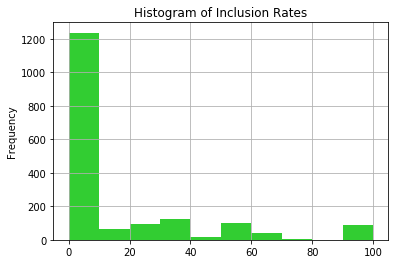

-- Mean inclusion rate 14.180915254237311
-- Median inclusion rate 0.0
--------------------------

For each predicted text, how much of it is extra content not in the test paragraph?


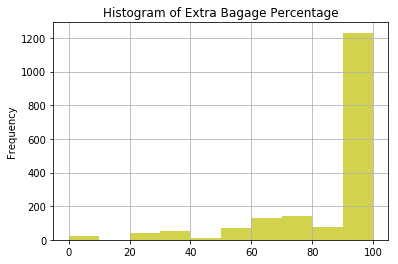

-- mean bagage rate:  87.45789503386008
-- median bagage rate:  100.0
----------------

What is the distribution of lengths of the word tokenized test texts.


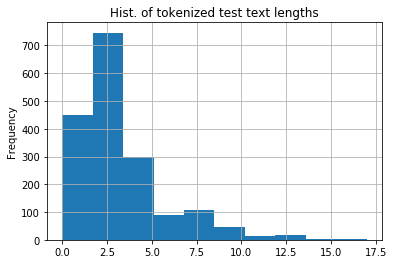

-- Mean tokenized test length  3.3188487584650113
-- Median tokenized test length 3.0
-- Range of tokenized test lengths 17.0
------------------------------

What is the distribution of lengths of the word tokenized test texts.


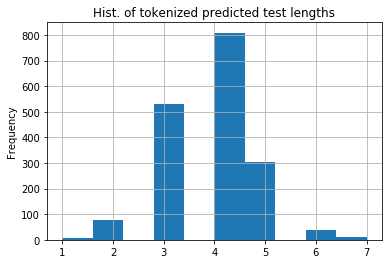

-- mean tokenized predicted text lenghts 3.8318284424379234
-- median tokenized predicted text lenghts 4.0
-- range of tokenized predicted text lenghts 6.0
------------------------------



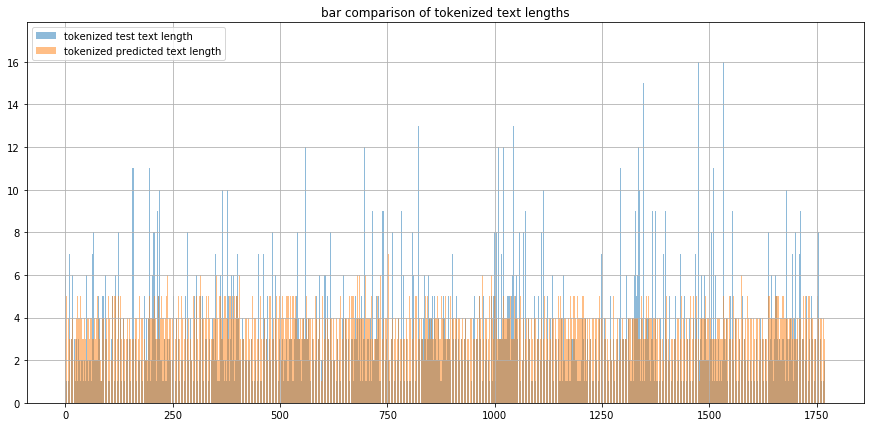

In [44]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test text, how many of them are 100% included in the predicted text?")
print(round(100*(share_rprchs_prgrph_df.predtext_totinc.sum())/len(share_rprchs_prgrph_df.predtext_totinc), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
print('For each test text, how much of it is included in the corresponding predicted text?')
share_rprchs_prgrph_df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.predtext_inclpct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.predtext_inclpct.median())
print("--------------------------")
print("")

# report extra baggage rate
print('For each predicted text, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.predtext_bggpct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.predtext_bggpct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.predtext_bggpct.median())
print("----------------")
print("")

# report lengths of tokenized test strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.testtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized test text lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test length ', np.mean(share_rprchs_prgrph_df.testtext_tknzdlen))
print('-- Median tokenized test length', share_rprchs_prgrph_df.testtext_tknzdlen.median())
print('-- Range of tokenized test lengths', np.max(share_rprchs_prgrph_df.testtext_tknzdlen) - np.min(share_rprchs_prgrph_df.testtext_tknzdlen))
print("-"*30)
print("")

# report lengths of tokenized predicted strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.predtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted test lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted text lenghts', np.mean(share_rprchs_prgrph_df.predtext_tknzdlen))
print('-- median tokenized predicted text lenghts', share_rprchs_prgrph_df.predtext_tknzdlen.median())
print('-- range of tokenized predicted text lenghts', (np.max(share_rprchs_prgrph_df.predtext_tknzdlen)) - np.min(share_rprchs_prgrph_df.predtext_tknzdlen))
print("-"*30)
print("")
# plot overlay of each string's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.testtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.bar(height = share_rprchs_prgrph_df.predtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.title('bar comparison of tokenized text lengths')
plt.legend(['tokenized test text length', 'tokenized predicted text length'])
plt.grid()
plt.show()

In [50]:
list(set(share_rprchs_prgrph_df.data_key_friendly_name))

['Share Repurchase Intention',
 'Share Repurchase Utilization',
 'Amount Spent on Share Repurchases',
 'Share Repurchase Count',
 'Share Repurchase Authorization Date',
 'Unknown Share Repurchase Data',
 'Share Repurchase Authorization']

## examine output

In [45]:
share_rprchs_prgrph_df.head(3)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,baggage_pct,tknzd_pred_par_len,pred_text,predtext_proba,predtext_totinc,predtext_inclpct,predtext_bggpct,testtext_totinc,predtext_tknzdlen,testtext_tknzdlen
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,40.00,110,"ization. on may 28, 2015 we",0.892602,True,100.00,25.00,NaN,4.0,3.0
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,40.91,110,cted by our share price as we,0.888659,False,16.67,66.67,NaN,3.0,6.0
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,47.27,110,2015 share repurchase program aut,0.956295,False,33.33,80.00,NaN,5.0,3.0


In [46]:
for i in range(len(share_rprchs_prgrph_df[0:20])):
    print('='*30, 'Compare test to predicted text', '='*30)
    print("DKFN:", share_rprchs_prgrph_df.data_key_friendly_name[i])
    print('-- Test Text:', share_rprchs_prgrph_df.text[i])
    print('  ', ". "*30)
    print('-- Pred Text:', share_rprchs_prgrph_df.pred_text[i])
    print('-'*60)

============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization Date
-- Test Text: May 28, 2015
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: ization. on may 28, 2015 we
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization
-- Test Text: The 2015 share repurchase program authorizes the purchase of up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: cted by our share price as we
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Intention
-- Test Text: remaining authorization to repurchase up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text:  2015 share repurchase progra

Share Repurchase Intention
For each test text, how many of them are 100% included in the predicted text?
0.88 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


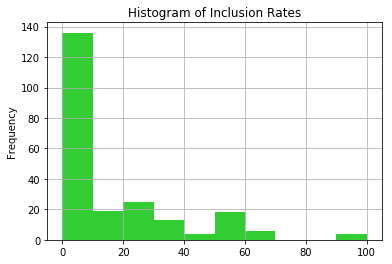

-- Mean inclusion rate 14.012800000000002
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Utilization
For each test text, how many of them are 100% included in the predicted text?
6.38 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


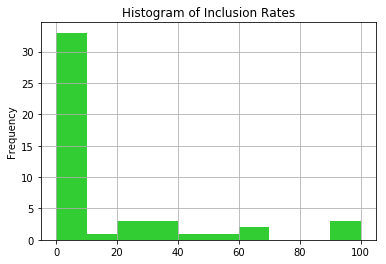

-- Mean inclusion rate 14.491489361702126
-- Median inclusion rate 0.0
--------------------------

Amount Spent on Share Repurchases
For each test text, how many of them are 100% included in the predicted text?
1.52 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


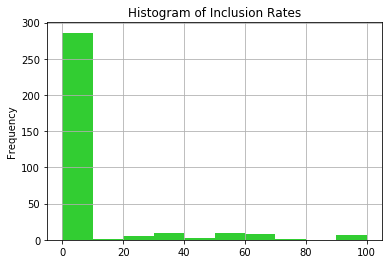

-- Mean inclusion rate 6.703323170731709
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Count
For each test text, how many of them are 100% included in the predicted text?
9.44 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


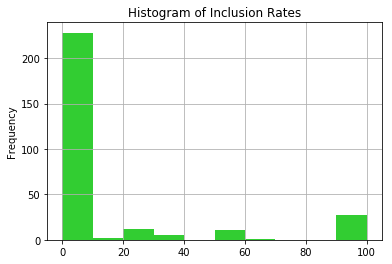

-- Mean inclusion rate 13.260454545454545
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Authorization Date
For each test text, how many of them are 100% included in the predicted text?
12.72 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


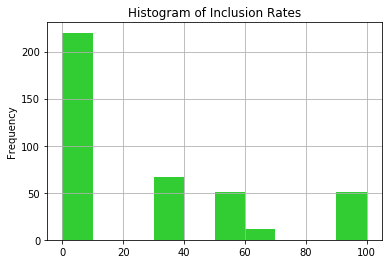

-- Mean inclusion rate 26.641271820448868
-- Median inclusion rate 0.0
--------------------------

Unknown Share Repurchase Data
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


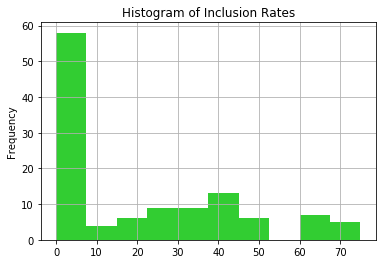

-- Mean inclusion rate 19.717606837606834
-- Median inclusion rate 11.11
--------------------------

Share Repurchase Authorization
For each test text, how many of them are 100% included in the predicted text?
0.82 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


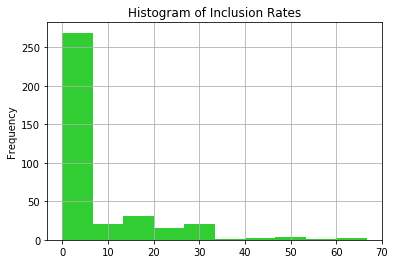

-- Mean inclusion rate 6.243032786885244
-- Median inclusion rate 0.0
--------------------------



In [47]:
# look at the inclusion rates by dkfn
for dkfn in list(set(share_rprchs_prgrph_df.data_key_friendly_name)):
    print("=======================================")
    print(dkfn)
    print("=======================================")
    report_inclusion(share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == dkfn])

## write out the csv

In [48]:
#share_rprchs_prgrph_df.to_csv('inv_tfidf_marg12.csv')

In [49]:
assert True == False

AssertionError: 

## test components above

In [ ]:
get_tfidf_ML_paragraph(nominees, string_filing, verbose = False, inverse= True)

## test tfidf vectorizer predictions

In [ ]:
for filing in training_filings_list[0:10]:
    '''# read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()'''
    
    
    nom_pars, string_filing = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 1 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

My Results are rather bad, based on visual inspection. 
- I have a feeling this is because the tfidf vectorizer is penalizing paragraphs that have precisely those terms that are most common in the training data. 
    - Well, all I know is that tfidf assigns low scores to terms that are super frequent across documents
        - i.e. 'authorized'
    - And it assigns high scores to terms that are frequent across documents
    - the result is that if 'authorized' appeard only once in each paragraph cell it would be scored very high
        - but the more it appears in each cell the more it gets penalized
- Then naive bayes is doing something (i know not what) to the effect of:
    - given that your paragraph has 'authorized' in it, how likely is it to be an authorization dkfn, as opposed to not. 
        - since all of or most of them have 'authorized' in there it probably thinks this term is rather irrelevant. 
        
 The problem is that my models are optimized to distinguish between relevant paragraphs, and to classify them based on their minor differences.
 - so it rewards paragraphs that have terms that are very rare in the training paragraphs
 - it's optimized to "split" hairs between good paragraphs, so it's trying to get as far away as possible from the "average" good paragraph, while still having "a toe" in the domain of their key tokens. 
 
If the model had been fit on noise and signal, it would be good at identifying noise. But since it was fit on signals 1 - 7, it is biased towards picking noise that is as unsimilar as possible to signals 1-7.

I, think... 🤔 

If my hypothesis is correct, then a count vectroizer should reward paragraphs that are most similar to training paragraphs
        

# Let's try out the results with a count vectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
second_nb_classifier = MultinomialNB()


In [ ]:
## Try out count vectorizer on 'authorization'
y_train = share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
y_test = share_rprchs_prgrph_df.authorization[[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
second_nb_classifier.fit(count_train, y_train)

In [ ]:
count_predictions = second_nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, count_predictions)

In [ ]:
for filing in training_filings_list[0:10]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # tfidf_vectorize the string into a sparse matrix
        #par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        
        # count_vectorize the string into a sparse matrix
        vectorized_par = count_vectorizer.transform([par])
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if second_nb_classifier.predict(vectorized_par)[0] == 1 and second_nb_classifier.predict_proba(vectorized_par)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = second_nb_classifier.predict_proba(vectorized_par)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

Again, the problem is that the model is optimized to reward the hairsplit differences between 7 signals. 
- so since 'authorization' appears in most of the 7 signals, it's relevance is ignored or downplayed
- whereas if 'further' appears more often in authorization signal than in the others, then it's going to pick noise paragraphs that have a hig count of the term 'further'

# 😜 if my models are so good at being bad, then what if I use the opposite of their prediction?

Ok, well let's try it for the count vectorizer. 
- although, I guess the key toks would get us in the "weather system"
- but the inverse count vecotrized prediction would reward the terms that were frequent across all of a dkfn's 'authorization' training paragraphs...

This did not work well for the inverse count prediction. I got 0/10 hits on 'authorized'

Try it again with the prediction being true, but then select the one with the lowes probability of being true. 
- no hits on 'authorized'
- 1/10 for 'repurchased'

😂 that worked for 5/10 with the tfidf on 'authorized'
- got 11/20 for 'authorized' with the inverse tfidf = 55%
- got 25/40 for 'authorized' with the inverse tfidf = 62.5%

So what is going on?
- if we think of each dkfn's paragraph cluster as a 'weather system' then the densest clouds represent the overlap, the commonalities between all that dkfn's paragraphs. all of that signals commonalities
- the tk_hits defines the 'weather system' 
- the tfidf rewards the 'edgiest' of the points, the outlier signals.
- the inverse tfidf rewards not what the dkfn paragraphs have in common, but rather what they have in common with the other signals. 
    - so it does a good job of getting us into the overlap between the signlas, it sort of defines the generica 'mean' signal. But it is not equipped to distinguish between noise and a given signal. 
    - it is only equipped to discern between the 7 signals. 
    
analogy:
- if i trained three models for classifying three instruments
    - rough electric guitar
        - the guitar model would determine that what stood out most about the electric guitar was it's low end growl and distortion
    - flute
       - the flute model would reward the sound of blowing
    - and drums
        - the drum model would reward percussion
- all three models would consider, rythm, and melody irrelevant (because all three instruments have those features).
- when 'released into the wild' 
    - the guitar model would prefer a diesel engine to an actual electric guitar
    - the flute model would prefer a tornado instead of any wind instrument
    - the drum model would prefer a jackhammer or construction zone over any percussion instrument
- the models would go out of their way to pass over instruments.


In [ ]:
for filing in training_filings_list[0:40]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 0 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)